# King County Housing sales analysis

### Table of contents
0. [Introduction](#0)
1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
2. [Data cleaning](#Data-Cleaning) 
3. [Further Exploration and Visualization](#Further-Exploration-and-Visualization)
4. [Model construction:](#Model-construction:)
    4.1 [Splitting into training and validation data](#Splitting-our-data)
    4.2 [Training our model](#Training-our-model)
    4.3 [Testing our model](#Testing-our-model)
5. [Conclusion](#Conclusion)

<a id='0'></a>

## 0. Introduction

Where to buy, and for how much? Is this a good location to invest in? What if we renovate, won't that help future resale?  I have a large house, but will buyers be put off by the age?

In this notebook we are informing real estate companies and housing development firms that there is a strong, predictable way for making informed decisions in King County. After our initial exploration of the available housing data, we wrote three key questions that we answer throughout the document. We loaded and described our raw data in section 1. After we wrote our questions and selected the most promising predictor variables we exported the data to a cleaning file (2) and then carried on exploring and illustrating the data in section 3. In section 4 we split our data for cross-validation, built our linear regression model and tested its effectiveness. We discuss the model and have written up answers to our questions in section 5, Conclusion. 

### Our questions:
    1. Is the amount of square foot of living space an effective predictor of house price and if so, by how much?
    2. Assuming that houses that have not been rennovated were last modified in the year that they were built, is there a correlation between the year that houses were last modified and their price? 
    3. If we plot the location of houses in KC across the county map, are there any particular geographical areas that have a strong correlation with price?
    
##### Sub questions:    
     - what is the level of spending on square footage (during building or rennovation) that will typically lead to a profit when selling the house)?
      - If building houses at the same cost, will location be a factor?
      - Is this a good indication for maximising profits for a development company?

##### 1. "How did you pick the question(s) that you did?" -

We tried putting ourselves in the shoes of our most likely clients and imagined what would the most useful and the most actionable outcomes, given the data. 
Combined with performing a basic EDA on our available data and using the correlation matrix we formed our hypotheses and developed a model. After selecting 5 variables with high coefficients with price, we checked them against each other for multicollinearity. We then focussed on those variables in our data cleaning. 

##### 2. "Why are these questions important from a business perspective?" - 

We imagined what kind of comapnies would be analysing this kind of data:
        - real estate companies focussed on sales
        - housing development firms focussed on maximising price and minimising cost.
These questions are relevant for maximising profit margin, through cost minimisation in building or targetting 
marketing. Having a solid evidence for convincing the seller of the price.

##### 3. "How did you decide on the data cleaning options you performed?" - 

With an eye towards efficiency, we focussed extensively on the variables that were relevant to our hypotheses. The majority of houses have a 0 value for the year that they were renovated in. We took that to mean that no renovation had occurred and we decided to create a new value for the year the house was last modified (renovated or just the year it was built in) and use that as a predictor variable instead of the yr_built and the yr_renovated variables.
To facilitate easier computation with pandas native methods we changed the dtype of the date to datetime format. 
We computed the values of price per square foot for each property and we added a column that included the straight-line distance from the most expensive property and the property with the highest price per square foot. 

##### 4. "Why did you choose a given method or library?" - 

Pandas was used for loading and manipulating the dataframe. 
Numpy excelled at mathematical operations and providing measures of dispersion. 
Seaborn library was used for the EDA visualizations because of its lighting quick usability and aesthetic properties. 
Folium was used for the geographical vizualizations / analysis because it was user-friendly and didn't require us to modify the coordinate variables to DMS format. 
Statsmodels and Scipy were used for model-building as they offered a wide array of statistical analyses and inbuilt model goodness checkers. 


##### 5. "Why did you select those visualizations and what did you learn from each of them?" 

The scatter matrix and heatmap gave us an excellent bird's eye view of our data and meant that we could 
    a. pursue target variables that were more likely to have high correlatios and 
    b. identify which variales had clearly skewed distributions and a higher likelihood of needing cleaning.
    
The histogram of our raw data helped visualize the distribution and normality of the data. 
The boxplots were used for comparing the effect of the two subgroups we created in our data (i.e. renovated vs not renovated). 
Scatter plots were initially used for quick, temporary visualization of hypotheses (e.g wheter location has an discernible influence on the price) and were afterwards used for a full illustration of our model's predictive capabilities.
QQ plots were used to assess our model's normality. 
Our heatmap provides the geographical distribution of price and helps explain one of the answers to our hypotheses. 


##### 6. "Why did you pick those features as predictors?" 

Relevant in both a business setting and found that there was a correlation worth exploring following plotting the heatmap.

##### 7. "How would you interpret the results?"- 

Generally our best predictor was square footage of living space, but within certain limits. It was less accurate for high values of either price or square footage. 
Geographical location did affect price (as seen in the heatmap), not in a way that we expected it to (i.e. not focussed around a particular central area, such as central Seattle). It also had a relatively low R^2 value.  
Houses that had been renovated did have a higher average price, however the year in which houses were most recently updated was a consistently poor predictor of price.

##### 8. "How confident are you in the predictive quality of the results?" - 

Our model is unlikely to be due to chance, given our consistently low P-values. Multicollinearity is shown to be absent due to consistently low correlations between our chosen predictor variables. We have assumed normal distributions, which has not necessarily been the case, and our data generally passes the tests for homoscedasticity (except at the very extremes of our data). 

##### 9. "What are some of the things that could cause the results to be wrong?" - 

Non-normal distributions would invalidate our model. 





In [914]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from datetime import datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols
import folium
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge
import scipy.stats as stats
sns.set_style(style='darkgrid')
sns.set_palette("bright")
import warnings
warnings.filterwarnings('ignore')

<a id='Exploratory-Data-Analysis'></a>

## 1. Exploratory Data Analysis

Here we begin by exploring the broad outlines of our data set and investigating if there are any salient features that could be helpful in our deeper analysis. 

In [915]:
df = pd.read_csv('kc_house_data.csv');

In [916]:
df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0         NaN   0.0  ...      7        1180            0.0   
1      7242     2.0         0.0   0.0  ...      7        2170          400.0   
2     10000     1.0         0.0   0.0  ...      6         770            0.0   
3      5000     1.0         0.0   0.0  ...      7        1050          910.0   
4      8080     1.0         0.0   0.0  ...      8        1680            0.0   

  yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0     1955           0.0    98178  47.5112 -122.257           1340        5650  
1     1951        1991.0    98125  47.7210 -122.319           1690        7639  
2     1933           NaN    98028  47.7379 -122.233           2720        8062  
3     1965           0.0    98136  47.5208 -122.393           1360        5000  
4     1987           0.0    98074  47.6168 -122.045           1800        7503  

[5 rows x 21 columns]

In [917]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [918]:
len(df)

21597

In [919]:
# beginning to build a very broad overview of the raw data
df.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.159700e+04  2.159700e+04  21597.000000  21597.000000  21597.000000   
mean   4.580474e+09  5.402966e+05      3.373200      2.115826   2080.321850   
std    2.876736e+09  3.673681e+05      0.926299      0.768984    918.106125   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.123049e+09  3.220000e+05      3.000000      1.750000   1430.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.159700e+04  21597.000000  19221.000000  21534.000000  21597.000000   
mean   1.509941e+04      1.494096      0.007596      0.233863      3.409825   
std    4.141264e+04      0.539683      0.086825      0.765686      0.650546   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.040000e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.618000e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.068500e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

              grade    sqft_above      yr_built  yr_renovated       zipcode  \
count  21597.000000  21597.000000  21597.000000  17755.000000  21597.000000   
mean       7.657915   1788.596842   1970.999676     83.636778  98077.951845   
std        1.173200    827.759761     29.375234    399.946414     53.513072   
min        3.000000    370.000000   1900.000000      0.000000  98001.000000   
25%        7.000000   1190.000000   1951.000000      0.000000  98033.000000   
50%        7.000000   1560.000000   1975.000000      0.000000  98065.000000   
75%        8.000000   2210.000000   1997.000000      0.000000  98118.000000   
max       13.000000   9410.000000   2015.000000   2015.000000  98199.000000   

                lat          long  sqft_living15     sqft_lot15  
count  21597.000000  21597.000000   21597.000000   21597.000000  
mean      47.560093   -122.213982    1986.620318   12758.283512  
std        0.138552      0.140724     685.230472   27274.441950  
min       47.155900   -122.519000     399.000000     651.000000  
25%       47.471100   -122.328000    1490.000000    5100.000000  
50%       47.571800   -122.231000    1840.000000    7620.000000  
75%       47.678000   -122.125000    2360.000000   10083.000000  
max       47.777600   -121.315000    6210.000000  871200.000000

In [920]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

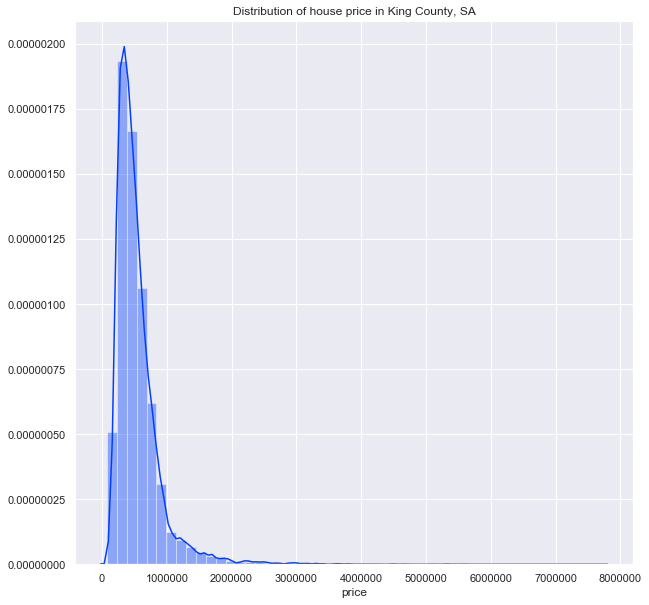

In [921]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Distribution of house price in King County, SA')
sns.distplot(df['price'], ax = ax);

In [922]:
df.price.describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

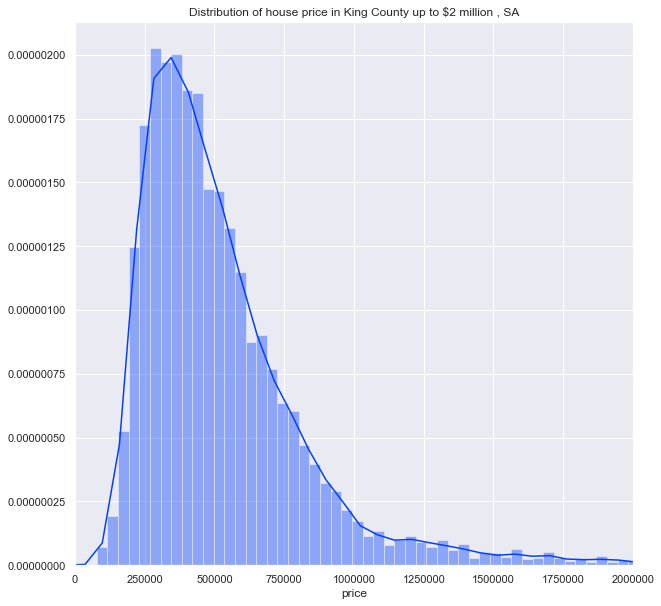

In [923]:
fig, ax = plt.subplots(figsize=(10,10))
plt.xlim(0,2000000)
ax.set_title('Distribution of house price in King County up to $2 million , SA')

sns.distplot(df['price'], ax = ax, bins = 200);

To give us a bird's eye overview of the data, we plotted a scatter matrix, paying particular attention to anything that correlated with price and a heatmap to find the highest coefficients our heatmap showed that grade, sqft_living and location were the optimal non-multicollinear variables. 

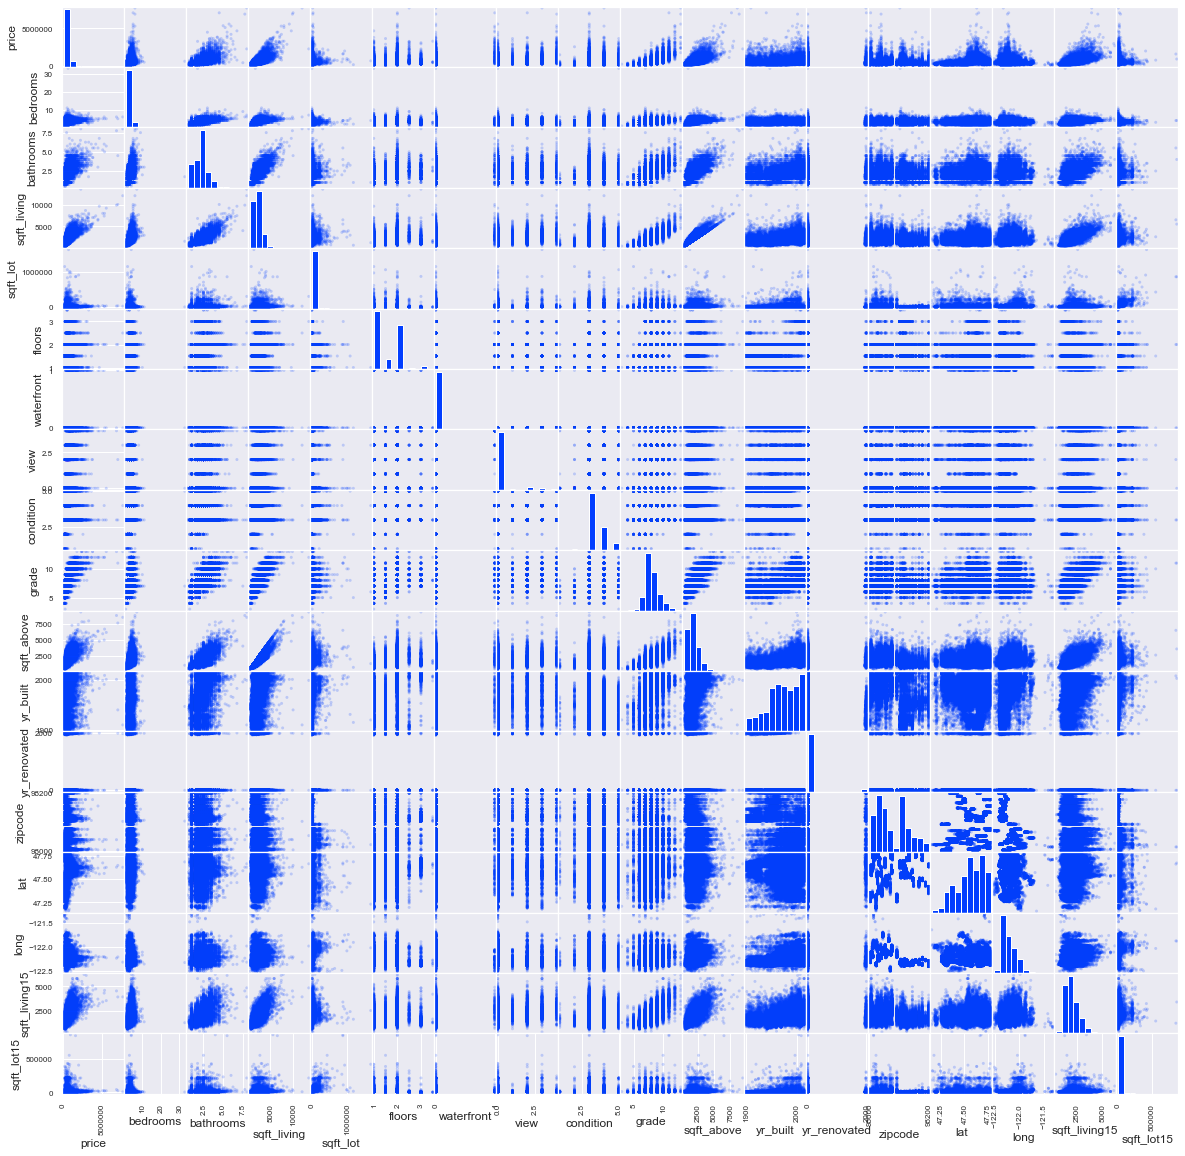

In [924]:
# Checking for obvious correlations, skewed data and categorical data (or lack thereof)

ax.set_title("Scatter matrix of all data variables")
pd.plotting.scatter_matrix(df.drop(columns=['id']), alpha = 0.2, figsize = (20,20))
plt.show()

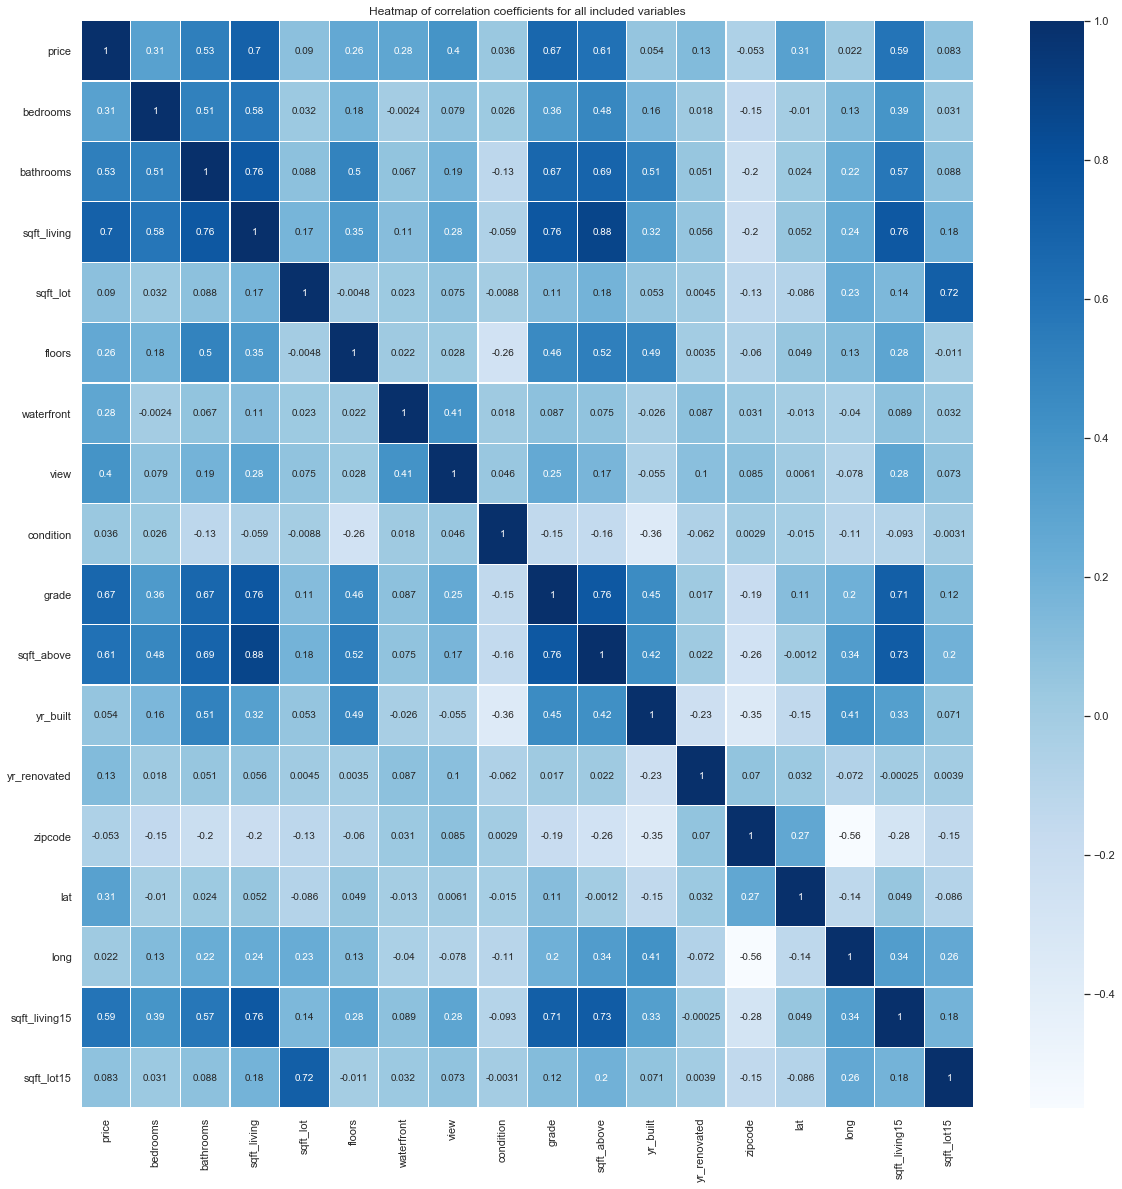

In [925]:
fig, ax =  plt.subplots(figsize = (20,20))
ax.set_title('Heatmap of correlation coefficients for all included variables')
matrix = df.drop(columns=['id']).corr()
sns.heatmap(matrix, annot = True, linewidths = 0.4, ax = ax, cmap = 'Blues', )

Since we couldn't clearly define grade and internet research threw up several interpretations of 'grade' (including bulding code, building quality and slope gradient) we decided to exclude grade from our further analysis.

<a id='Data-Cleaning'></a>

## 2. Data Cleaning 


In [926]:
df['grade'].value_counts()

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

In [927]:
df['yr_built'].describe()

count    21597.000000
mean      1970.999676
std         29.375234
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64

In [928]:

df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

Here we were checking for null values we found 3 variables that might need cleaning. However we discarded View because there were so few houses with a view (in cell below: view=0.0 has a count of 19422) and it doesn't seem like a scalable variable that our client could use. The same problem applies to the waterfront values (n=146).

In [929]:
df['view'].value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [930]:
df.waterfront.value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [931]:
df.isna().sum() # lots of yr_renovated null values. 

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [932]:
df['yr_renovated'].value_counts().head() # also a lot of hidden null values, so we decided to explore more

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
Name: yr_renovated, dtype: int64

Further exploration of other variables. 

In [933]:
df['bathrooms'].value_counts()

2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

In [934]:
df['bedrooms'].value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [935]:
df.loc[df['bedrooms'] == 33]

id       date     price  bedrooms  bathrooms  sqft_living  \
15856  2402100895  6/25/2014  640000.0        33       1.75         1620   

       sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
15856      6000     1.0         0.0   0.0  ...      7        1040   

       sqft_basement yr_built  yr_renovated  zipcode      lat     long  \
15856          580.0     1947           0.0    98103  47.6878 -122.331   

       sqft_living15  sqft_lot15  
15856           1330        4700  

[1 rows x 21 columns]

In [936]:
df.loc[df['bathrooms'] == 7.75] # exploring outliers in the data. 

id       date      price  bedrooms  bathrooms  sqft_living  \
9245  9208900037  9/19/2014  6890000.0         6       7.75         9890   

      sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
9245     31374     2.0         0.0   4.0  ...     13        8860   

      sqft_basement yr_built  yr_renovated  zipcode      lat    long  \
9245         1030.0     2001           0.0    98039  47.6305 -122.24   

      sqft_living15  sqft_lot15  
9245           4540       42730  

[1 rows x 21 columns]

In [937]:
df.loc[df['yr_renovated'] != 0].head()

id       date     price  bedrooms  bathrooms  sqft_living  \
1   6414100192  12/9/2014  538000.0         3       2.25         2570   
2   5631500400  2/25/2015  180000.0         2       1.00          770   
12   114101516  5/28/2014  310000.0         3       1.00         1430   
23  8091400200  5/16/2014  252700.0         2       1.50         1070   
26  1794500383  6/26/2014  937000.0         3       1.75         2450   

    sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
1       7242     2.0         0.0   0.0  ...      7        2170          400.0   
2      10000     1.0         0.0   0.0  ...      6         770            0.0   
12     19901     1.5         0.0   0.0  ...      7        1430            0.0   
23      9643     1.0         NaN   0.0  ...      7        1070            0.0   
26      2691     2.0         0.0   0.0  ...      8        1750          700.0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
1      1951        1991.0    98125  47.7210 -122.319           1690   
2      1933           NaN    98028  47.7379 -122.233           2720   
12     1927           NaN    98028  47.7558 -122.229           1780   
23     1985           NaN    98030  47.3533 -122.166           1220   
26     1915           NaN    98119  47.6386 -122.360           1760   

    sqft_lot15  
1         7639  
2         8062  
12       12697  
23        8386  
26        3573  

[5 rows x 21 columns]

At this stage we decided to export our data to another dedicated Jupyter notebook ("Data Cleaning") and then reimport the clean dataframe. Below is a summary of how we modified the data:

We added a new column for whether a house has been renovated or not. If there is a null value or zero for year of renovation, we've set it zero. We inspect the NaN values in yr_renovated and checked the measures of dispersion on yr_built to check our houses that had null values before deciding to either drop them or mark them as not renovated.
We've decided to replace Nan values with not renovated on the assumption that renovation would have been advertized otherwise when trying to sell the house. We therefore added a column for "year last updated" - houses with value zero for renovation will have their yr_built value used instead. 
We added a column that computed price per square foot, the distance to the highes priced property and the distance to the property with the highest price per square foot. 

In [938]:
clean_df = pd.read_csv('cleaned_data.csv')

In [939]:
clean_df = clean_df.drop(columns = 'Unnamed: 0')
clean_df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...      lat     long  sqft_living15  \
0      5650     1.0         NaN   0.0  ...  47.5112 -122.257           1340   
1      7242     2.0         0.0   0.0  ...  47.7210 -122.319           1690   
2     10000     1.0         0.0   0.0  ...  47.7379 -122.233           2720   
3      5000     1.0         0.0   0.0  ...  47.5208 -122.393           1360   
4      8080     1.0         0.0   0.0  ...  47.6168 -122.045           1800   

  sqft_lot15  datetime_date  renovated  yr_last_updated  price_per_sqft  \
0       5650     2014-10-13          0           1955.0      188.050847   
1       7639     2014-12-09          1           1991.0      209.338521   
2       8062     2015-02-25          0           1933.0      233.766234   
3       5000     2014-12-09          0           1965.0      308.163265   
4       7503     2015-02-18          0           1987.0      303.571429   

   dist_highest_price_prop  dist_highest_pricepersqft  
0                 0.135728                   0.221226  
1                 0.091288                   0.074650  
2                 0.140661                   0.161218  
3                 0.129541                   0.169506  
4                 0.278304                   0.349788  

[5 rows x 27 columns]

<a id='Further-Exploration-and-Visualization'></a>

## 3. Further exploration and visualization 


In [940]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         21597 non-null  int64  
 1   date                       21597 non-null  object 
 2   price                      21597 non-null  float64
 3   bedrooms                   21597 non-null  int64  
 4   bathrooms                  21597 non-null  float64
 5   sqft_living                21597 non-null  int64  
 6   sqft_lot                   21597 non-null  int64  
 7   floors                     21597 non-null  float64
 8   waterfront                 19221 non-null  float64
 9   view                       21534 non-null  float64
 10  condition                  21597 non-null  int64  
 11  grade                      21597 non-null  int64  
 12  sqft_above                 21597 non-null  int64  
 13  sqft_basement              21597 non-null  obj

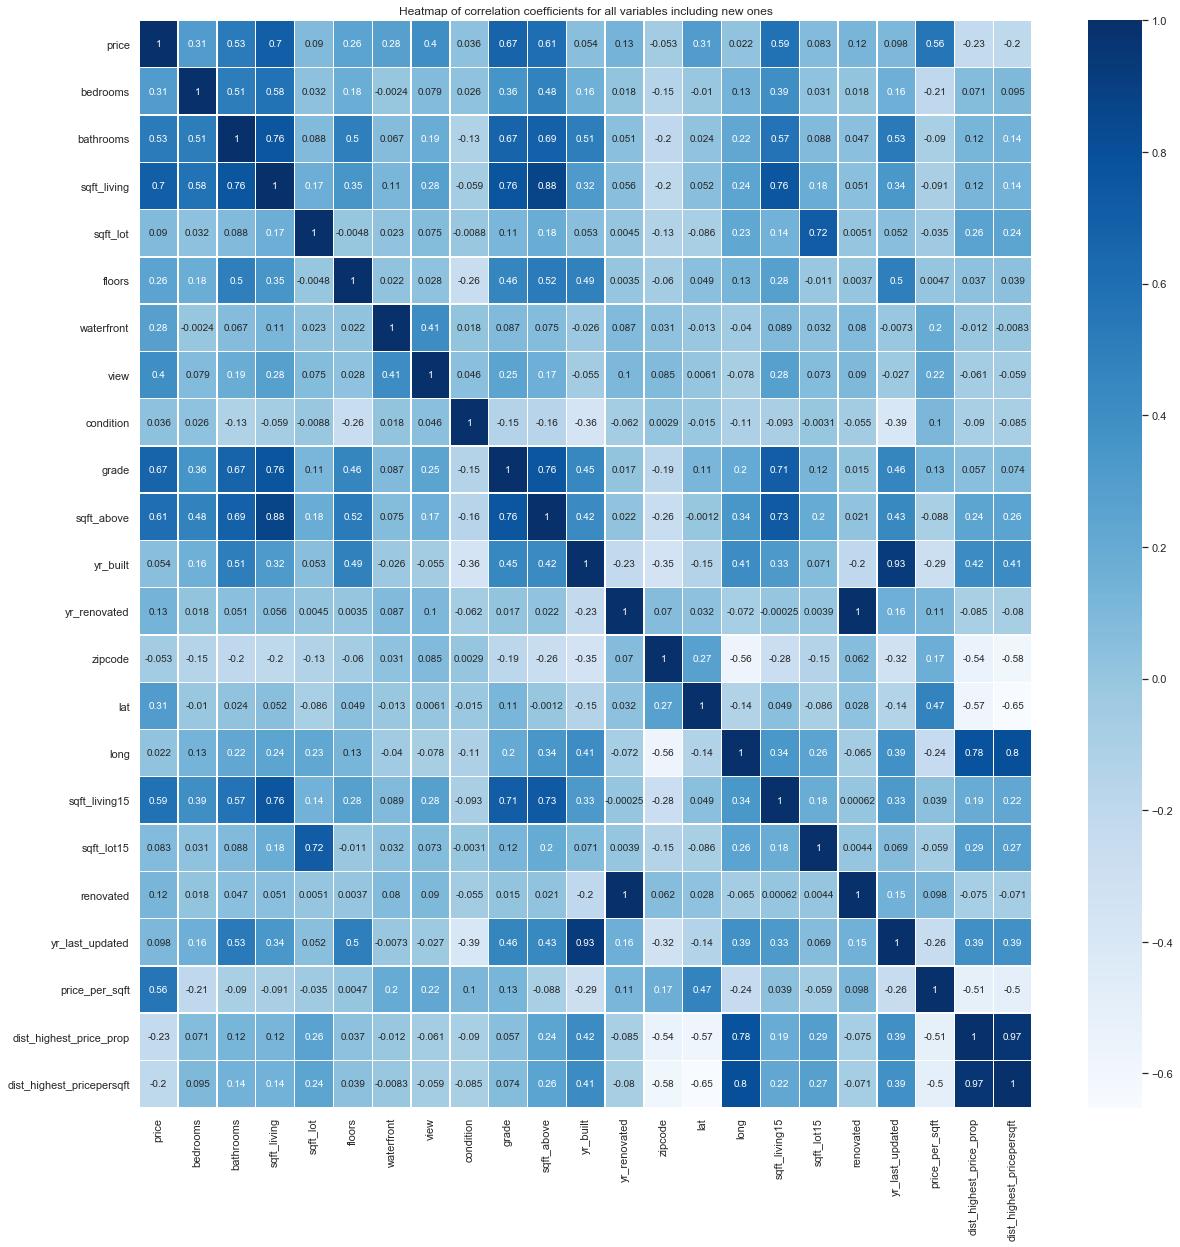

In [941]:
# we will checking for multicollinearity again, given our new variables we've computed:
fig, ax =  plt.subplots(figsize = (20,20))
ax.set_title('Heatmap of correlation coefficients for all variables including new ones')
matrix = clean_df.drop(columns=['id']).corr()
sns.heatmap(matrix, annot = True, linewidths = 0.4, ax = ax, cmap = 'Blues');

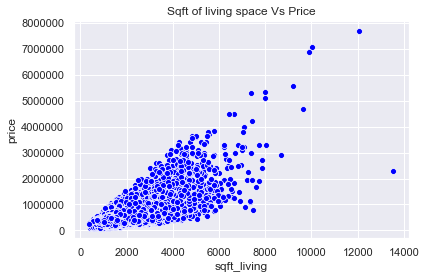

In [942]:
ax = plt.gca()
ax.set_title("Sqft of living space Vs Price")
sns.set(rc={'figure.figsize':(10,10)})
sns.scatterplot(x=clean_df['sqft_living'], y = clean_df['price'], color = 'blue', ax = ax);


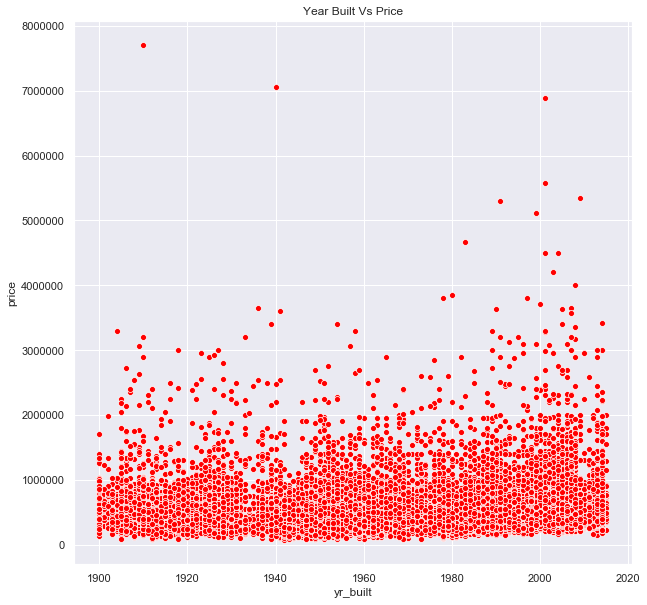

In [943]:
ax = plt.gca()
ax.set_title("Year Built Vs Price")
sns.set(rc={'figure.figsize':(10,10)})
sns.scatterplot(x=clean_df['yr_built'], y = clean_df['price'], color = 'red', ax = ax)


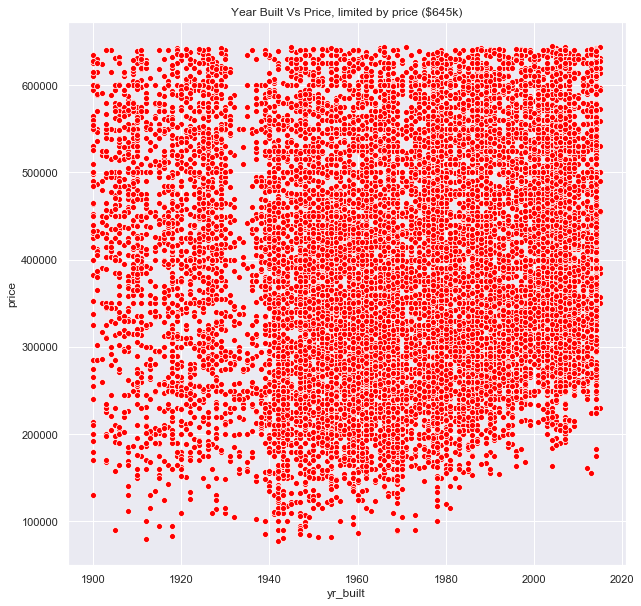

In [944]:
ax = plt.gca()
ax.set_title("Year Built Vs Price, limited by price ($645k)")
sns.set(rc={'figure.figsize':(10,10)})
sns.scatterplot(x=clean_df.loc[df.price < 645000]['yr_built'], y = clean_df.loc[df.price < 645000]['price'], color = 'red')

After attempting to plot with the full data for prices and yr_built we have replotted with outliers removed.
However, this did not help to reveal any meaningful patterns. Using our updated list from the clean df ('yr_last_updated') we've found a potentially more meaningful pattern. However, following regression analysis the age of update doesn't seem to dictate the price. 

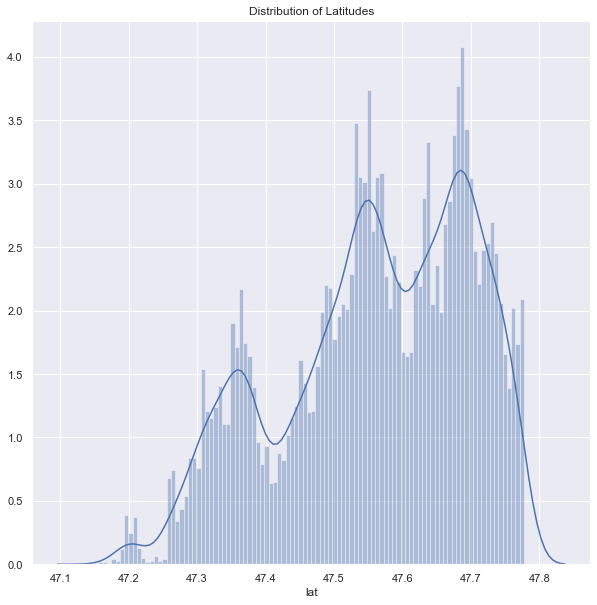

In [945]:
ax = plt.gca()
ax.set_title("Distribution of Latitudes")
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(clean_df.lat,bins=100);

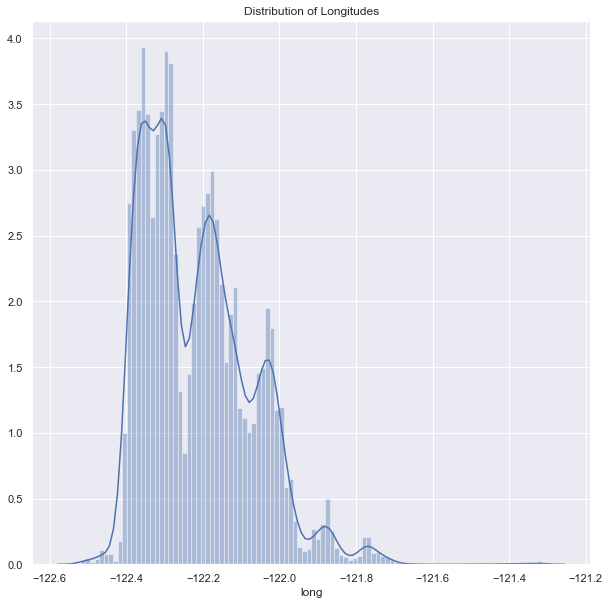

In [946]:
ax = plt.gca()
ax.set_title("Distribution of Longitudes")
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(clean_df.long, bins=100);

Looking at our distribution for latitude, we can see that the number of house sales in our data are skewed towards
the North of King County, Seattle. Also the distribution of houses along longitudinal lines conforms to our 
expectations, given that Seattle is in the West of the county. 

Below we also plotted a scatter of the latitude versus the price, given that the correlation between the two is 0.31. 

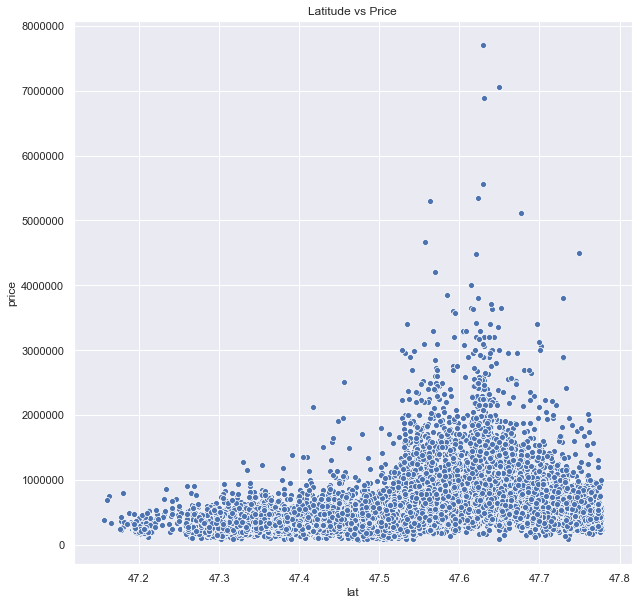

In [947]:
ax = plt.gca()
ax.set_title("Latitude vs Price")
sns.set(rc={'figure.figsize':(10,10)})
sns.scatterplot(x = clean_df.lat, y = clean_df.price);

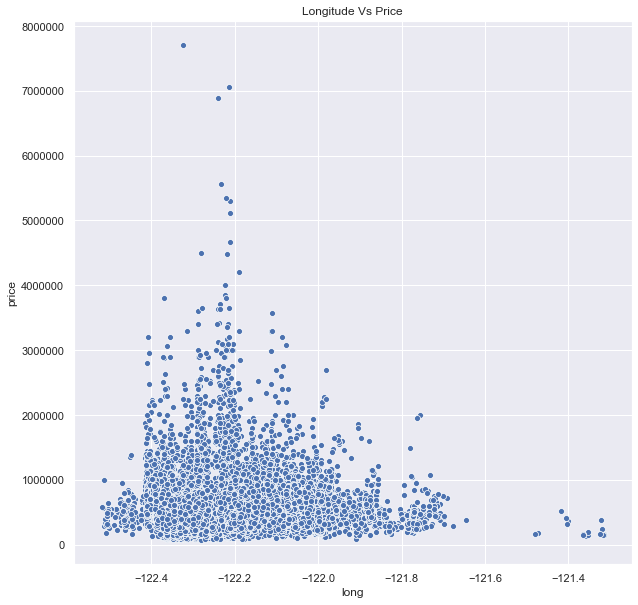

In [948]:
ax = plt.gca()
ax.set_title("Longitude Vs Price")
sns.set(rc={'figure.figsize':(10,10)})
sns.scatterplot(x = df.long, y = df.price);

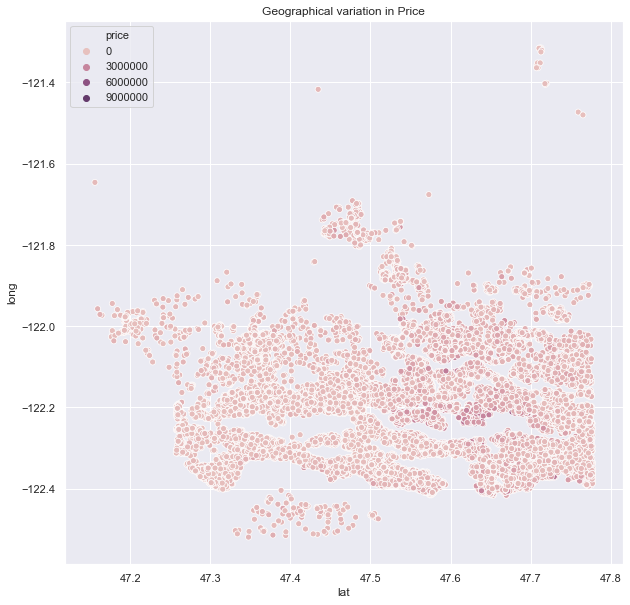

In [949]:
ax = plt.gca()
ax.set_title("Geographical variation in Price")
sns.set(rc={'figure.figsize':(10,10)})
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x=df.lat, y=df.long, hue=df.price, palette=cmap);

We wanted to explore the question of high prices being distributed around a central point. We investigated by choosing a famous landmark of Seattle, The Space Needle.

We found some correlation between prices and distance to the Space Needle, however a stronger correlation was found by pinpointing the most expensive property (absolute and price/square foot) and calculating the straight line distance from this.

In [950]:
needle_lat = 47.620422
needle_long = -122.349358
clean_df['dist_from_needle'] = np.sqrt((clean_df.long - needle_long)**2 + (clean_df.lat - needle_lat)**2)

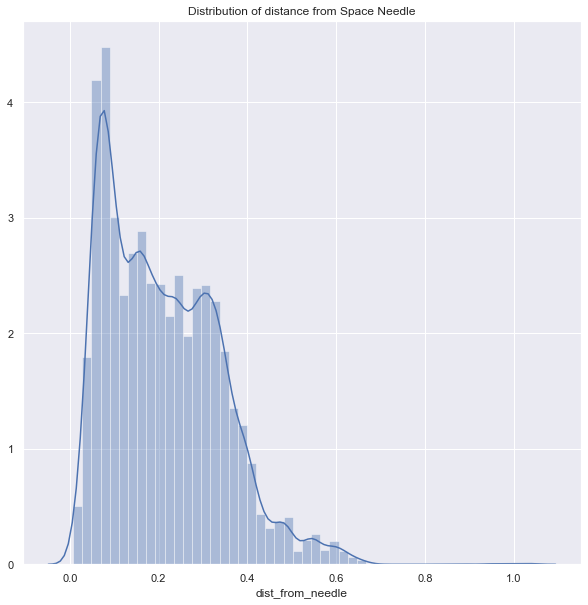

In [951]:
ax = plt.gca()
ax.set_title("Distribution of distance from Space Needle")
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(clean_df.dist_from_needle);

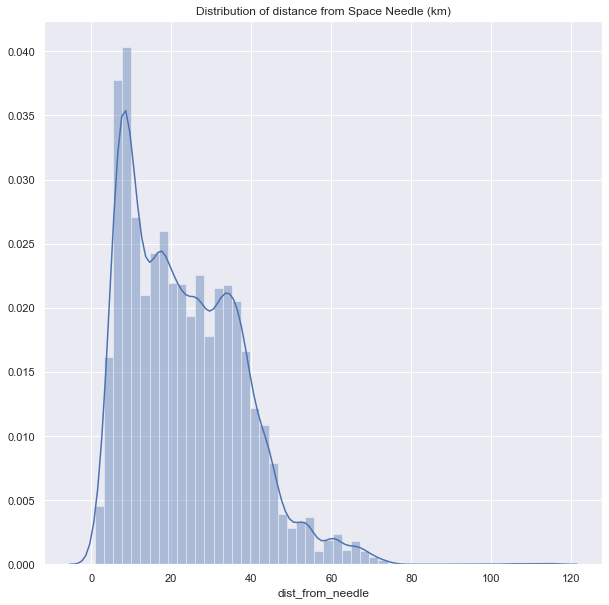

In [952]:
ax = plt.gca()
ax.set_title("Distribution of distance from Space Needle (km)")
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(111*clean_df.dist_from_needle); # Converting distance from degrees to KM

In [953]:
round((clean_df.dist_from_needle.describe()) * 111,2)

count    2397267.00
mean          23.36
std           14.34
min            0.82
25%           10.85
50%           21.34
75%           33.50
max          115.27
Name: dist_from_needle, dtype: float64

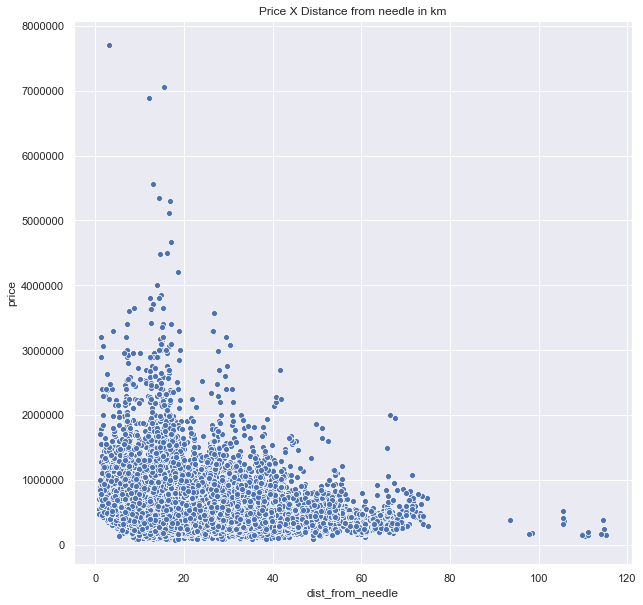

In [954]:
ax = plt.gca()
ax.set_title("Price X Distance from needle in km")
sns.scatterplot(x=111*clean_df.dist_from_needle, y = clean_df.price);

For our last feature engineering task, we plotted the the year of last rennovation (yr_last_updated) against price to investigate for useful patterns. There seems to be a very week correlation here at best, where a more recent update gives a higher price, but this seems mainly driven by the outliers. For clarity's sake we replotted this one cell further below for the houses that were updated in this millenium. 

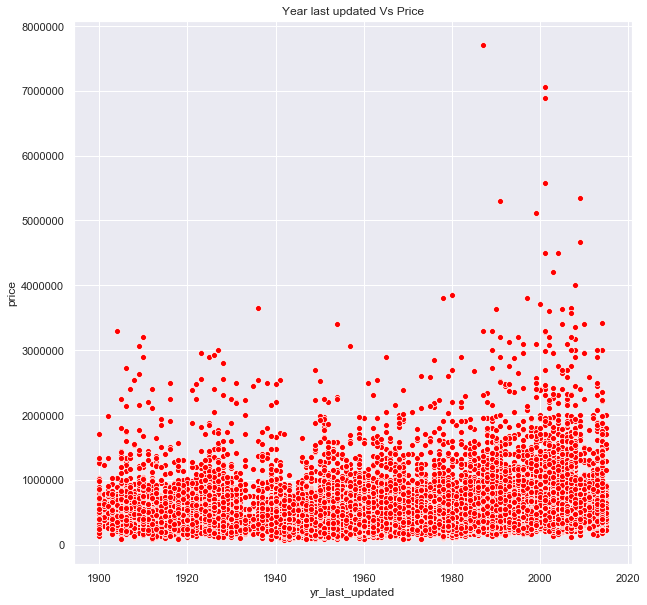

In [955]:
ax = plt.gca()
ax.set_title("Year last updated Vs Price")

sns.scatterplot(x=clean_df['yr_last_updated'], y = clean_df['price'], color = 'red');

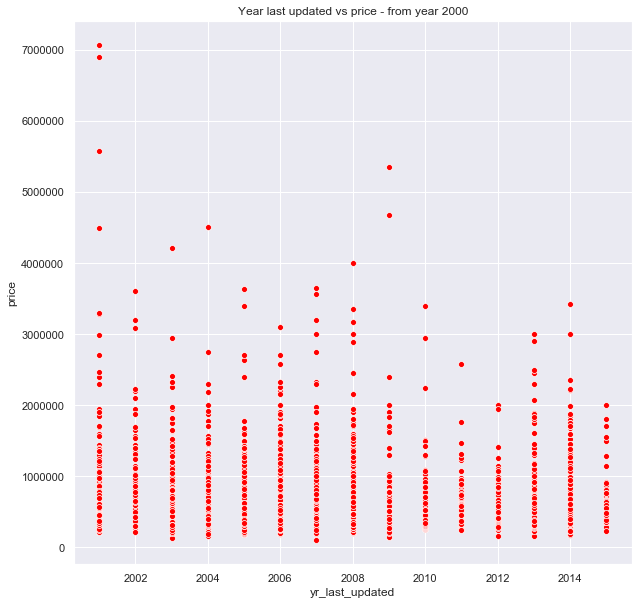

In [956]:
ax = plt.gca()
ax.set_title("Year last updated vs price - from year 2000")

sns.scatterplot(x=clean_df.loc[( (clean_df.yr_last_updated > 2000))]['yr_last_updated'], y = df.loc[((clean_df.yr_last_updated > 2000))]['price'], color = 'red');

We've subcatgorized the houses by renovation and showed the different attributes for the two subgroups. After we plotted the full distribution of for the two groups we did the same but limiting the price at 2 000 000 USD to account for outliers. Based on this difference, we decided it would be worthwhile to take rennovation into account as a binary variable.


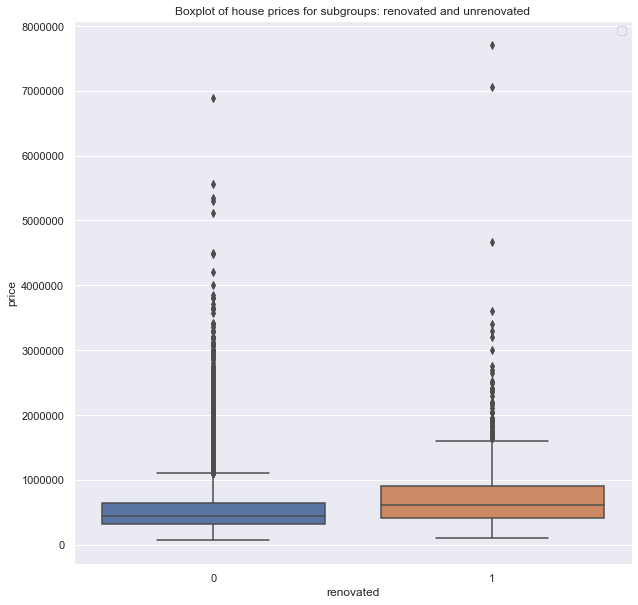

In [957]:
ax = plt.gca()
ax.set_title("Boxplot of house prices for subgroups: renovated and unrenovated")
ax.legend(labels=['Not renovated','Renovated'])
sns.set(rc={'figure.figsize':(10,10)})
sns.boxplot(x = clean_df['renovated'], y = clean_df['price']);

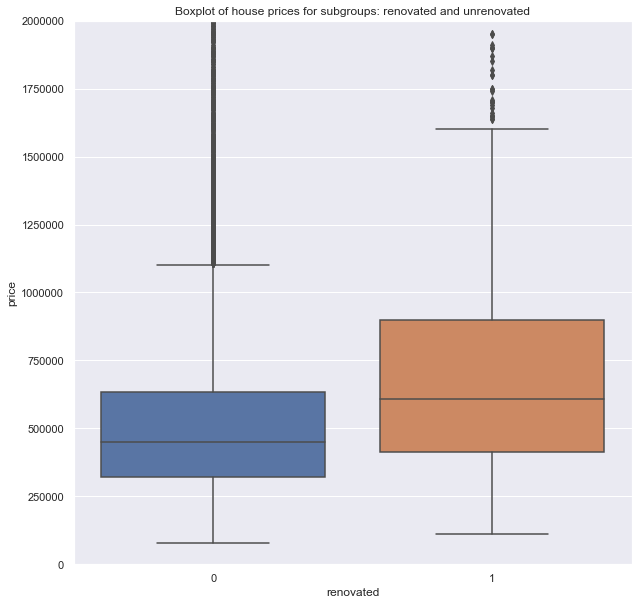

In [958]:
# zoomed in to remove outliers
ax = plt.gca()
ax.set_title("Boxplot of house prices for subgroups: renovated and unrenovated")
sns.set(rc={'figure.figsize':(10,10)})
sns.boxplot(x = clean_df['renovated'], y = clean_df['price'])

plt.ylim([0,2000000]);


<a id='Model-construction:'></a>

## 4. Model construction:


<a id='Splitting-our-data'></a>

### 4.1 Splitting into training and validation data and scaling our data

We're taking our data and training our statsmodels linear regression on 80% of our data (marked as "train_df") and then testing it in section 4.3 on our validation data (test_df). We'll also be checking for the normality and similarity of our split data sets before using them. 

In [959]:
len(clean_df)

21597

In [960]:
from sklearn.model_selection import train_test_split

clean_df_prep = clean_df[['price', 'sqft_living','sqft_living15', 'renovated','yr_last_updated',
                          'price_per_sqft','dist_highest_price_prop','dist_highest_pricepersqft',
                         'dist_from_needle',]]
clean_df_prep['log_sqft_living'] = np.log(clean_df_prep['sqft_living'])
clean_df_prep['log_price'] = np.log(clean_df_prep['price'])

x_train, x_test, y_price_train, y_price_test = train_test_split(clean_df_prep.drop(columns=['price', 'price_per_sqft', 'log_price']),
                                                                 clean_df_prep[['price', 'price_per_sqft','log_price']], 
                                                                test_size=.2, random_state=1234, shuffle=False)

In [961]:
len(x_train)

17277

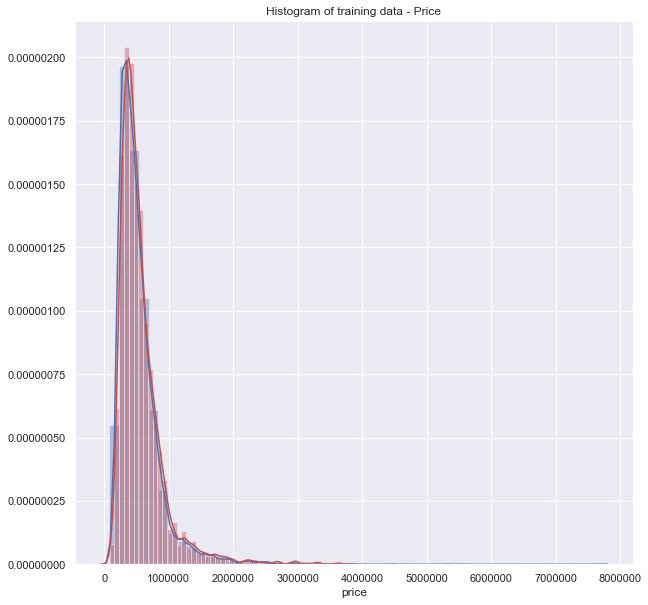

In [962]:
ax = plt.gca()
ax.set_title("Histogram of training data - Price")
sns.set(rc={'figure.figsize':(12,12)})
sns.distplot(y_price_train['price'],color='b')
sns.distplot(y_price_test['price'],color='r');

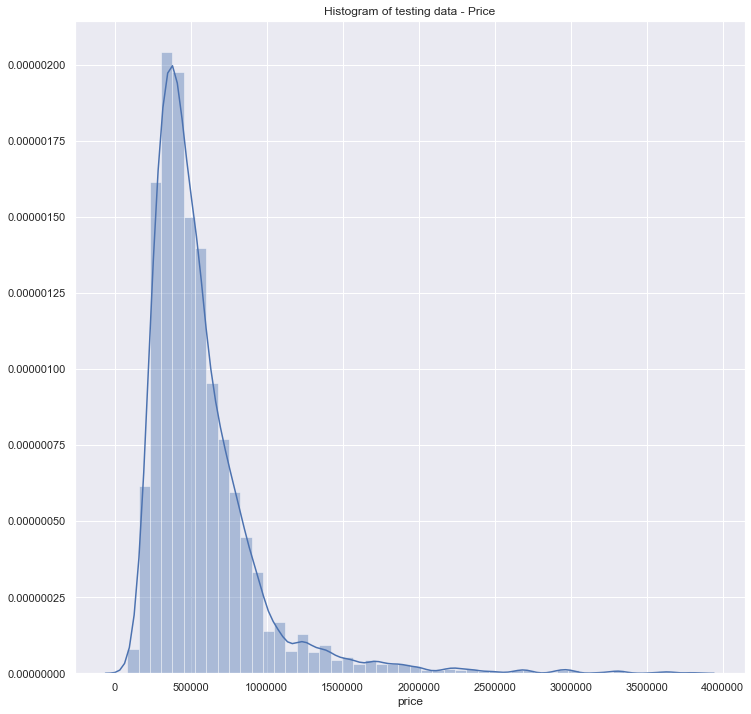

In [963]:
ax = plt.gca()
ax.set_title("Histogram of testing data - Price")
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(y_price_test['price']);

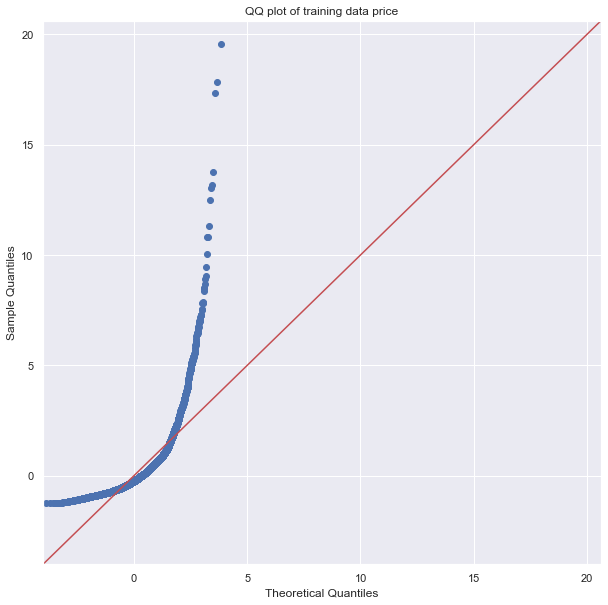

In [964]:
ax = plt.gca()
ax.set_title("QQ plot of training data price")
sns.set(rc={'figure.figsize':(15,15)})
price_data_train = (y_price_train.price-y_price_train.price.mean())/y_price_train.price.std()
fig = sm.graphics.qqplot(price_data_train,dist=stats.norm, line='45', fit=True, ax=ax)
fig.show();

Upon testing for the data's normality, it becomes self-evident that our data is being very heavily influenced by our outliers. We decide to use the log of price instead. 

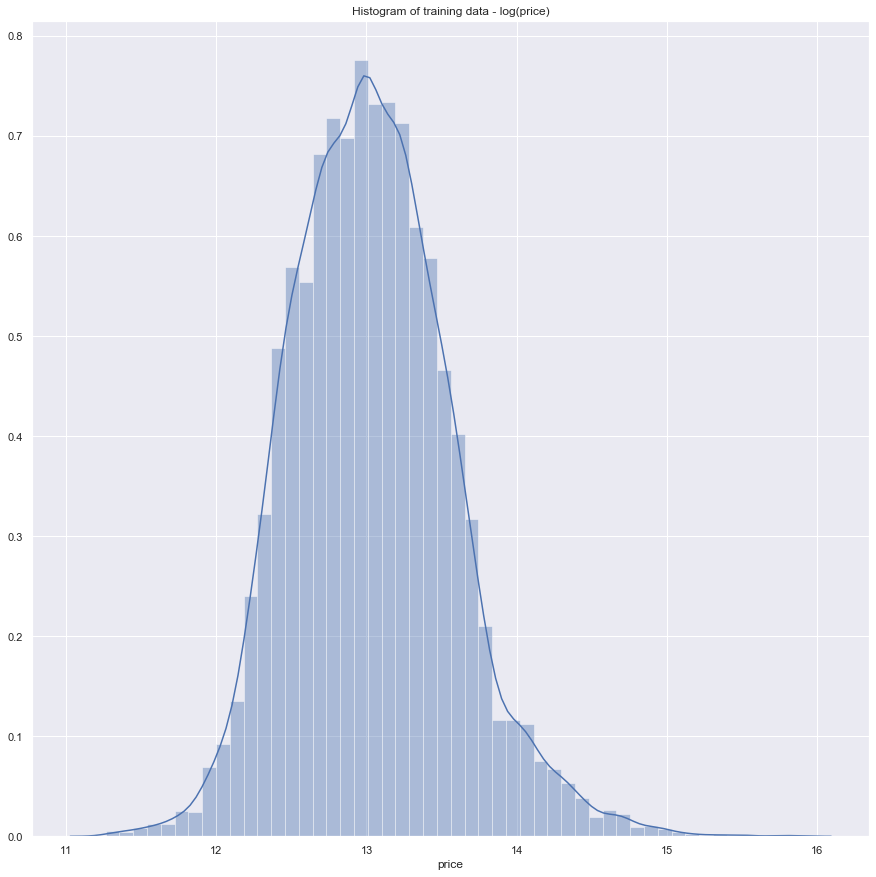

In [965]:
ax = plt.gca()
ax.set(xlabel='log(price)', title='Histogram of training data - log(price)')
sns.distplot(np.log(y_price_train.price));


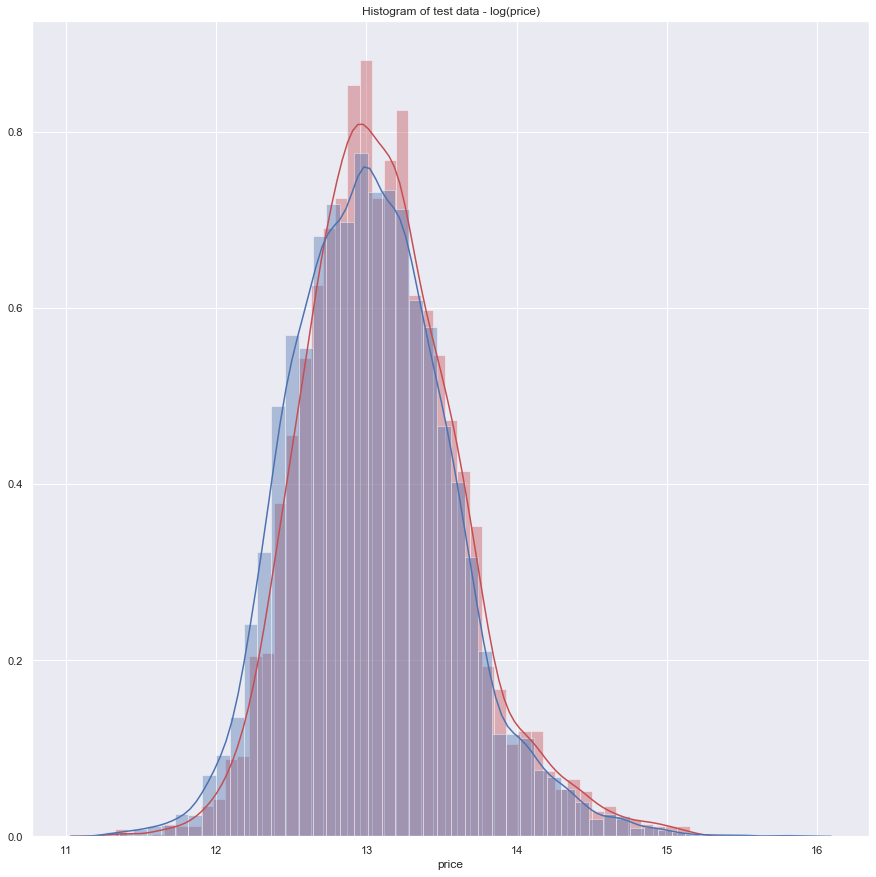

In [966]:
ax = plt.gca()
sns.set(rc={'figure.figsize':(12,12)})
ax.set(xlabel='log(price)', title='Histogram of test data - log(price)')
sns.distplot(np.log(y_price_test.price),color='r')
sns.distplot(np.log(y_price_train.price),color='b');

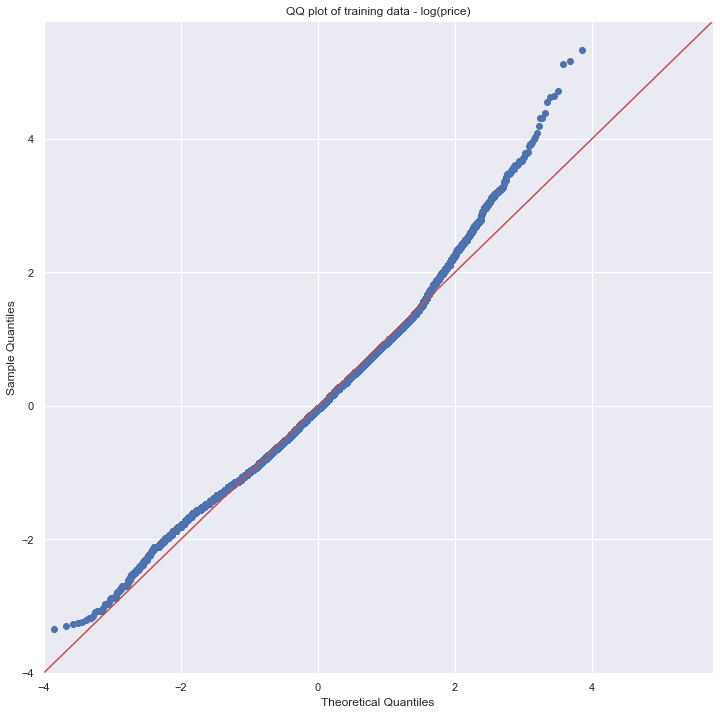

In [967]:
ax = plt.gca()
sns.set(rc={'figure.figsize':(12,12)})
ax.set( title='QQ plot of training data - log(price)')
price_data_train = (np.log(y_price_train.price)-np.log(y_price_train.price).mean())/np.log(y_price_train.price).std()
fig = sm.graphics.qqplot(price_data_train,dist=stats.norm, line='45', fit=True,ax=ax)
fig.show()


For the most part of our training and testing data there seemes to be a normal distribution, however model validity could be questioned at higher priced data. Fortunately both the training and testing data are similarly distributed.

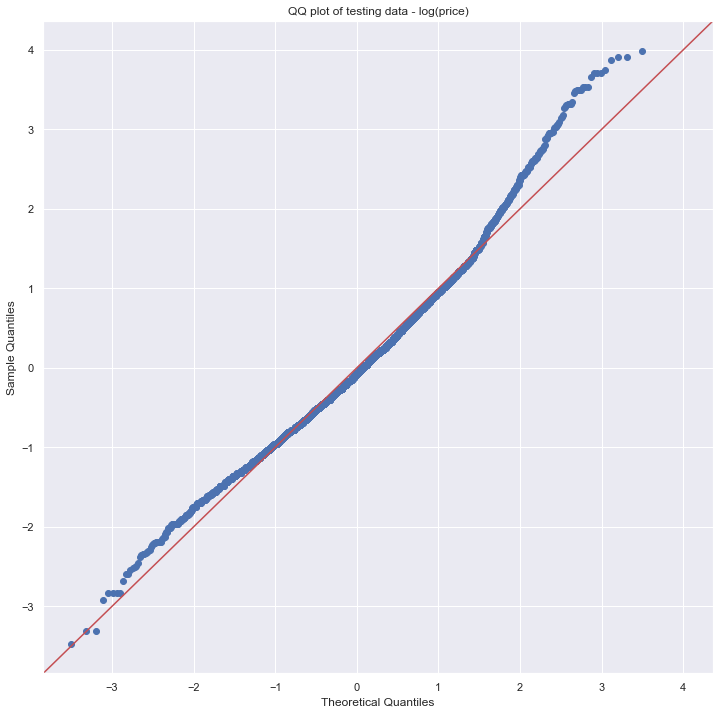

In [968]:
ax = plt.gca()
sns.set(rc={'figure.figsize':(12,12)})
ax.set( title='QQ plot of testing data - log(price)')
price_data_test = (np.log(y_price_test.price)-np.log(y_price_test.price).mean())/np.log(y_price_test.price).std()
fig = sm.graphics.qqplot(price_data_test,dist=stats.norm, line='45', fit=True,ax=ax)
fig.show()

Given the usefulness of using the log(price), we've modified the clean_df to have a log of price additionally and split the data again. 
The log(price) therefore represents the marginal increase in price.

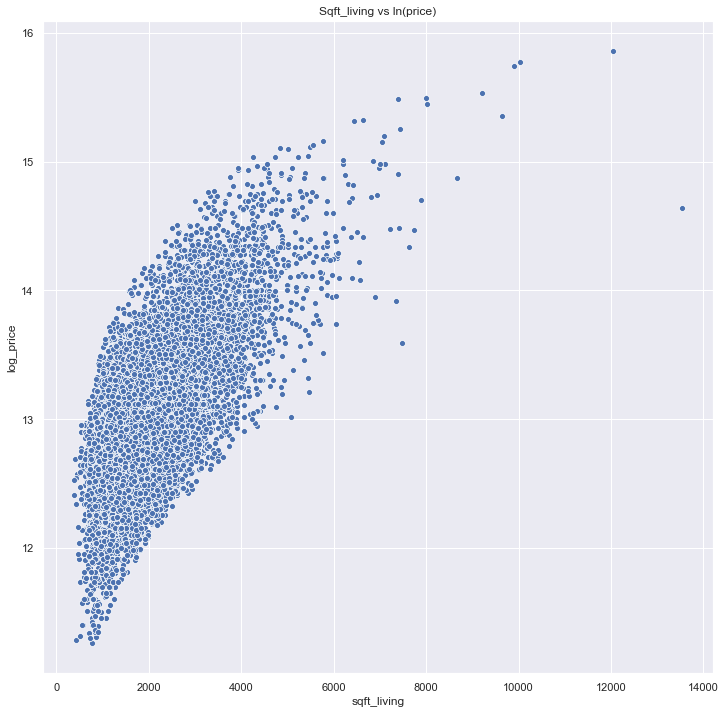

In [969]:
clean_df['log_price'] = np.log(clean_df.price)

fig, ax1 = plt.subplots(figsize = (12,12))
ax1.set_title(label='Sqft_living vs ln(price)')
# To illustrate the difference, we've plotted below the log(price) vs sqft_living
sns.scatterplot(x = x_train['sqft_living'], y =y_price_train['log_price'], ax=ax1);


Before we start using our data, we show some final checks of our test and train data to make sure no data leakage has occurred. 

In [970]:
x_test.head()

sqft_living  sqft_living15  renovated  yr_last_updated  \
17277         2270           2020          0           1967.0   
17278         1470           1470          0           2005.0   
17279         1280           1160          0           1976.0   
17280         2830           2830          0           2005.0   
17281         1970           1980          0           1908.0   

       dist_highest_price_prop  dist_highest_pricepersqft  dist_from_needle  \
17277                 0.113933                   0.147193          0.139892   
17278                 0.335332                   0.414451          0.358907   
17279                 0.276135                   0.320331          0.304031   
17280                 0.232554                   0.320288          0.248635   
17281                 0.052185                   0.095652          0.076736   

       log_sqft_living  
17277         7.727535  
17278         7.293018  
17279         7.154615  
17280         7.948032  
17281         7.585789

In [971]:
y_price_test.shape

(4320, 3)

In [972]:
y_price_test.head()

price  price_per_sqft  log_price
17277  624900.0      275.286344  13.345347
17278  379770.0      258.346939  12.847321
17279  340000.0      265.625000  12.736701
17280  515500.0      182.155477  13.152893
17281  600000.0      304.568528  13.304685

The final step, before running our models, was now to scale our data, done below.

In [973]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [974]:
train_scaled_df = pd.DataFrame(x_train_scaled, columns=x_train.columns)
test_scaled_df = pd.DataFrame(x_test_scaled, columns=x_test.columns)

In [975]:
x_test.shape

(4320, 8)

In [976]:
y_price_test.columns

Index(['price', 'price_per_sqft', 'log_price'], dtype='object')

In [977]:
test_scaled_df.columns

Index(['sqft_living', 'sqft_living15', 'renovated', 'yr_last_updated',
       'dist_highest_price_prop', 'dist_highest_pricepersqft',
       'dist_from_needle', 'log_sqft_living'],
      dtype='object')

In [978]:
x_train.shape

(17277, 8)

In [979]:
train_scaled_df.shape

(17277, 8)

In [980]:
# for the purpose of statsmod OLS, we will now merge the feature and target columns back again             
train_scaled_df = pd.concat([train_scaled_df, y_price_train], axis=1)

In [981]:
test_scaled_df = pd.concat([test_scaled_df.reset_index(), y_price_test.reset_index()], axis=1)


In [982]:
test_scaled_df.shape

(4320, 13)

In [983]:
train_scaled_df.tail()

sqft_living  sqft_living15  renovated  yr_last_updated  \
17272     0.780757      -2.249538  -0.194056        -0.340278   
17273     0.537340       0.096125  -0.194056        -2.327568   
17274     3.425153       3.406777  -0.194056        -0.557073   
17275     1.511009      -0.913401  -0.194056         1.610879   
17276     0.238601       0.066433  -0.194056        -0.087350   

       dist_highest_price_prop  dist_highest_pricepersqft  dist_from_needle  \
17272                -0.820450                  -1.051318         -0.732648   
17273                -1.259828                  -0.805828         -1.169245   
17274                -1.292054                  -0.882376         -1.122089   
17275                -1.153299                  -1.319435         -1.106846   
17276                -0.700723                  -0.709380         -0.555773   

       log_sqft_living      price  price_per_sqft  log_price  
17272         0.911398   378000.0      136.956522  12.842649  
17273         0.714029   775000.0      305.118110  13.560618  
17274         2.393490  2250000.0      436.893204  14.626441  
17275         1.420844  1350000.0      394.736842  14.115615  
17276         0.447000   380000.0      167.400881  12.847927

In [984]:
test_scaled_df.tail()

index  sqft_living  sqft_living15  renovated  yr_last_updated  \
4315   4315    -0.580166      -0.661019  -0.194056         1.430217   
4316   4316     0.282859      -0.215640  -0.194056         1.610879   
4317   4317    -1.144451      -1.418164  -0.194056         1.430217   
4318   4318    -0.502715      -0.839171  -0.194056         1.249554   
4319   4319    -1.144451      -1.418164  -0.194056         1.394084   

      dist_highest_price_prop  dist_highest_pricepersqft  dist_from_needle  \
4315                -1.030981                  -1.421414         -1.035017   
4316                -0.608364                  -0.478974         -0.787318   
4317                -1.277810                  -0.825189         -1.210110   
4318                 0.575308                   0.690920          0.650045   
4319                -1.275794                  -0.823693         -1.209022   

      log_sqft_living  index     price  price_per_sqft  log_price  
4315        -0.490376  21592  360000.0      235.294118  12.793859  
4316         0.488504  21593  400000.0      173.160173  12.899220  
4317        -1.453776  21594  402101.0      394.216667  12.904459  
4318        -0.384081  21595  400000.0      250.000000  12.899220  
4319        -1.453776  21596  325000.0      318.627451  12.691580

<a id='Training-our-model'></a>

### 4.2 Training our model


<a id='univariatesqft_living'></a>

Modelling phase - we have our 3 predictor variables: amount of square feet of living space (sqft_living); the distance from the highest priced property in the county (dist_highest_pricepersqft); the amount of years elapsed since the last update of the property (yr_last_updated) and the average amount of square feet of living space amongst the nearest 15 houses (sqft_living15).

We iterated through all univariate models with the aforementioned variables. Although sqft_living has a high R^2 value, we tested for heteroskedasticity, and realized that our high-price outliers seemed to have much larger variance and affecting our model. We deal with that issue below. 


In [985]:

formula_sqft_living = 'log_price~sqft_living'
model_1 = ols(formula = formula_sqft_living, data = train_scaled_df).fit()
model_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                 1.572e+04
Date:                Mon, 13 Apr 2020   Prob (F-statistic):               0.00
Time:                        07:00:43   Log-Likelihood:                -7924.8
No. Observations:               17277   AIC:                         1.585e+04
Df Residuals:                   17275   BIC:                         1.587e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      13.0341      0.003   4475.266      0.000      13.028      13.040
sqft_living     0.3652      0.003    125.384      0.000       0.359       0.371
==============================================================================
Omnibus:                        1.297   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.523   Jarque-Bera (JB):                1.282
Skew:                           0.021   Prob(JB):                        0.527
Kurtosis:                       3.009   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

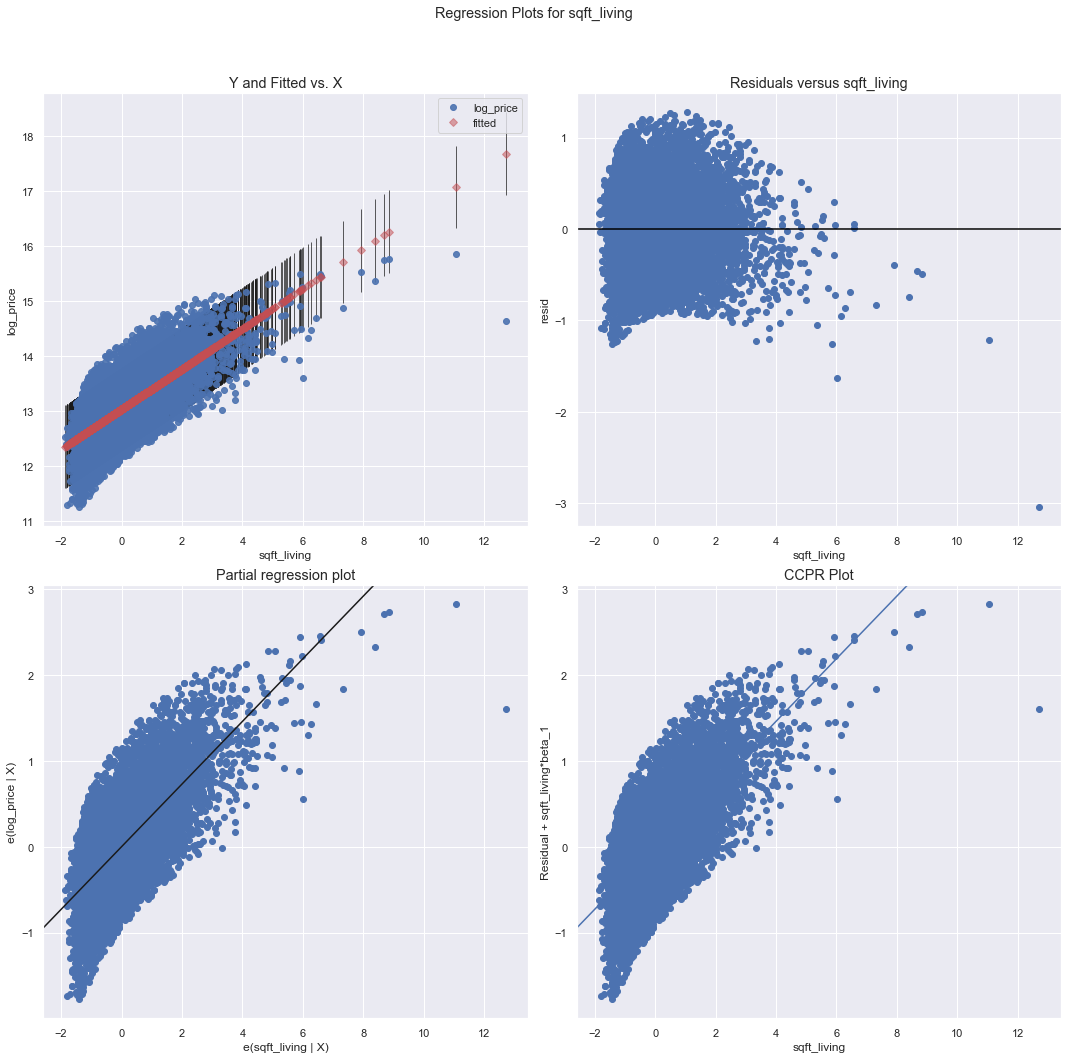

In [986]:
fig = plt.figure(figsize=(15,15))
fig = sm.graphics.plot_regress_exog(model_1, 'sqft_living',fig=fig)
plt.show()

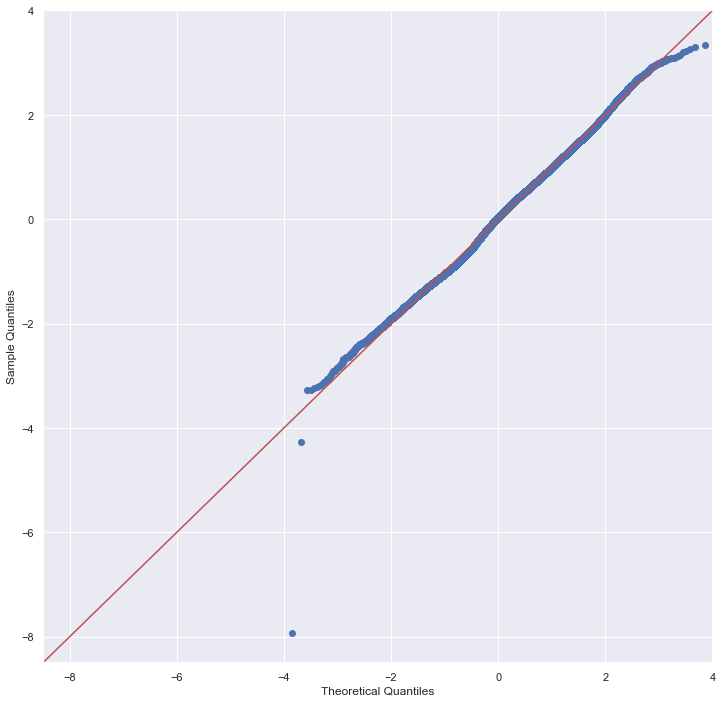

In [987]:
residuals_log_price_sqft_living = model_1.resid
fig = sm.graphics.qqplot(residuals_log_price_sqft_living,dist=stats.norm, line='45', fit=True)
fig.show()

In [988]:
train_scaled_df.head()

sqft_living  sqft_living15  renovated  yr_last_updated  \
0    -0.967421      -0.943093  -0.194056        -0.520941   
1     0.570533      -0.423484   5.153157         0.779831   
2    -1.421062       1.105651  -0.194056        -1.315857   
3    -0.104396      -0.913401  -0.194056        -0.159615   
4    -0.414200      -0.260178  -0.194056         0.635301   

   dist_highest_price_prop  dist_highest_pricepersqft  dist_from_needle  \
0                -0.523990                  -0.208270         -0.531046   
1                -0.884361                  -1.200399         -0.829690   
2                -0.483981                  -0.614446         -0.355584   
3                -0.574154                  -0.558346         -0.800576   
4                 0.632186                   0.661927          0.737732   

   log_sqft_living     price  price_per_sqft  log_price  
0        -1.107559  221900.0      188.050847  12.309982  
1         0.741928  538000.0      209.338521  13.195614  
2        -2.121840  180000.0      233.766234  12.100712  
3         0.098114  604000.0      308.163265  13.311329  
4        -0.268154  510000.0      303.571429  13.142166

In [989]:
formula_log_price_log_sqft_living = 'log_price~log_sqft_living'
model_1_1 = ols(formula = formula_log_price_log_sqft_living, data = train_scaled_df).fit()
model_1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                 1.418e+04
Date:                Mon, 13 Apr 2020   Prob (F-statistic):               0.00
Time:                        07:00:45   Log-Likelihood:                -8337.4
No. Observations:               17277   AIC:                         1.668e+04
Df Residuals:                   17275   BIC:                         1.669e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          13.0341      0.003   4369.660      0.000      13.028      13.040
log_sqft_living     0.3552      0.003    119.089      0.000       0.349       0.361
==============================================================================
Omnibus:                      103.009   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.270
Skew:                           0.143   Prob(JB):                     3.38e-21
Kurtosis:                       2.778   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

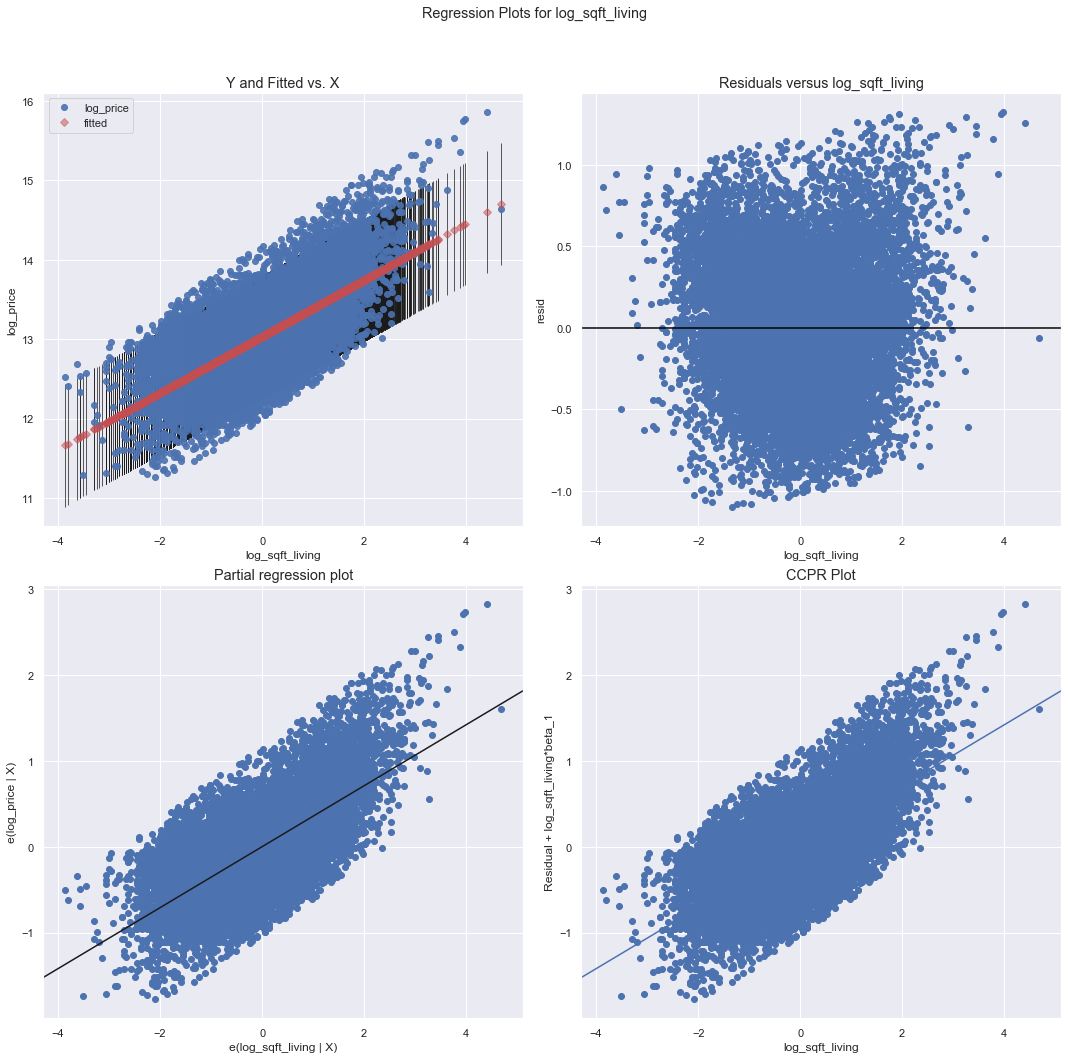

In [990]:
fig = plt.figure(figsize=(15,15))
fig = sm.graphics.plot_regress_exog(model_1_1, 'log_sqft_living',fig=fig)
plt.show()

So far we're acquiring improved results with a logarithm of the sqft_living. Our heteroskedasticity has decreased significantly. We're now going to plot the distribution of residuals to confirm the improvement. We can see below that it has improved significantly.

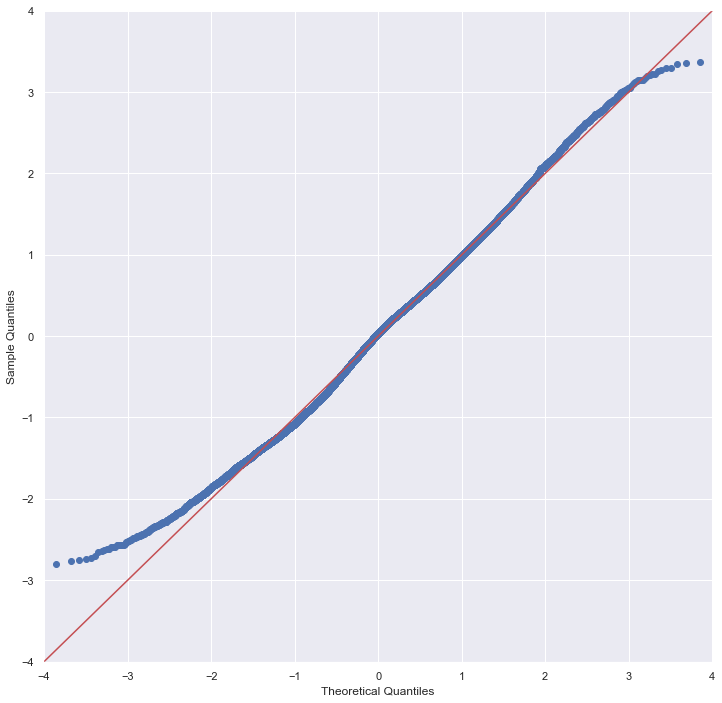

In [991]:
residuals_log_price_log_sqft_living = model_1_1.resid
fig = sm.graphics.qqplot(residuals_log_price_log_sqft_living,dist=stats.norm, line='45', fit=True)
fig.show()

In [994]:
formula_dist_highest_pricepersqft = 'log_price~dist_highest_pricepersqft'
model_2 = ols(formula = formula_dist_highest_pricepersqft, data = train_scaled_df).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     1472.
Date:                Mon, 13 Apr 2020   Prob (F-statistic):          3.09e-309
Time:                        07:02:29   Log-Likelihood:                -12808.
No. Observations:               17277   AIC:                         2.562e+04
Df Residuals:                   17275   BIC:                         2.564e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    13.0341      0.004   3373.335      0.000      13.027      13.042
dist_highest_pricepersqft    -0.1483      0.004    -38.373      0.000      -0.156      -0.141
==============================================================================
Omnibus:                      813.690   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1063.416
Skew:                           0.476   Prob(JB):                    1.21e-231
Kurtosis:                       3.756   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

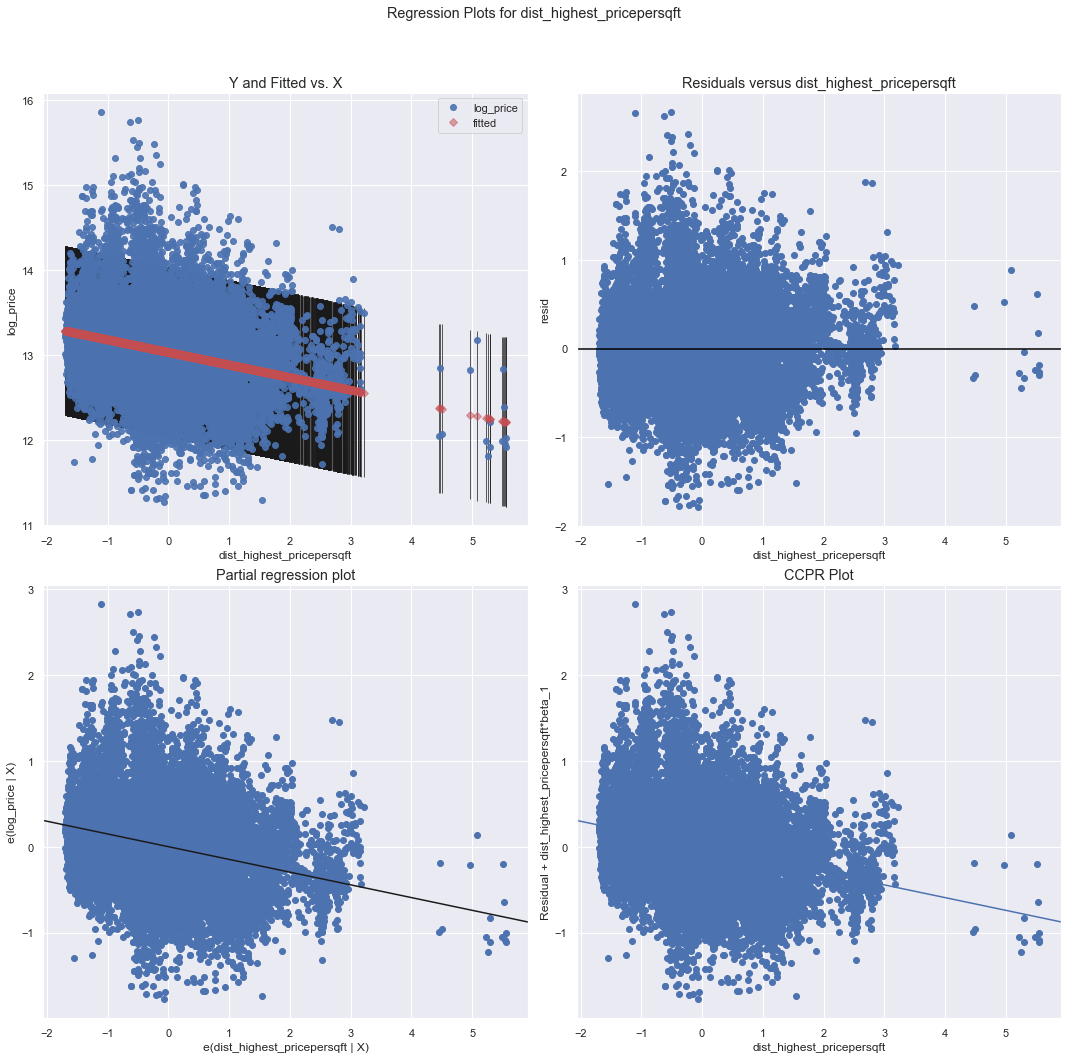

In [995]:
fig = plt.figure(figsize=(15,15))
fig = sm.graphics.plot_regress_exog(model_2, 'dist_highest_pricepersqft',fig=fig)
plt.show()

In [996]:
formula_yr_last_updated = 'log_price~yr_last_updated'
model_3 = ols(formula = formula_yr_last_updated, data = train_scaled_df).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     187.0
Date:                Mon, 13 Apr 2020   Prob (F-statistic):           2.40e-42
Time:                        07:02:31   Log-Likelihood:                -13422.
No. Observations:               17277   AIC:                         2.685e+04
Df Residuals:                   17275   BIC:                         2.686e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          13.0341      0.004   3255.629      0.000      13.026      13.042
yr_last_updated     0.0547      0.004     13.674      0.000       0.047       0.063
==============================================================================
Omnibus:                      667.083   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              820.131
Skew:                           0.437   Prob(JB):                    8.14e-179
Kurtosis:                       3.613   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Originally we considered and tried below using the distance to the highest priced property (similar to our experimentation with using the Space Needle). However, given the split in data sets, it's highly possible that the highest priced property in either set will differ massively, so we will only be using distance to highest priced per sqft property, since it takes into account size. 


In [997]:
formula_dist_highest_price_prop = 'log_price~dist_highest_price_prop'
model_4 = ols(formula = formula_dist_highest_price_prop, data = train_scaled_df).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     1633.
Date:                Mon, 13 Apr 2020   Prob (F-statistic):               0.00
Time:                        07:02:32   Log-Likelihood:                -12735.
No. Observations:               17277   AIC:                         2.547e+04
Df Residuals:                   17275   BIC:                         2.549e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  13.0341      0.004   3387.733      0.000      13.027      13.042
dist_highest_price_prop    -0.1555      0.004    -40.409      0.000      -0.163      -0.148
==============================================================================
Omnibus:                      646.846   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              836.801
Skew:                           0.409   Prob(JB):                    1.95e-182
Kurtosis:                       3.703   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [998]:
formula_sqft_living15 = 'log_price~sqft_living15'
model_5 = ols(formula = formula_sqft_living15, data = train_scaled_df).fit()
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                 1.155e+04
Date:                Mon, 13 Apr 2020   Prob (F-statistic):               0.00
Time:                        07:02:33   Log-Likelihood:                -9091.1
No. Observations:               17277   AIC:                         1.819e+04
Df Residuals:                   17275   BIC:                         1.820e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        13.0341      0.003   4183.144      0.000      13.028      13.040
sqft_living15     0.3349      0.003    107.490      0.000       0.329       0.341
==============================================================================
Omnibus:                      204.154   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              223.153
Skew:                           0.235   Prob(JB):                     3.49e-49
Kurtosis:                       3.299   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<a id='multivariatemodel'></a>


Based on the univariate models we've run so far, we started selecting variables to use in our multi-variable model. We chose sqft_living, dist_highest_pricepersqft and yr_last_updated. Although we'd previously elected to use the log of the price with respect to sqft_living, we decided to run the model with normal price first to compare marginal improvements. 

In [999]:

analytic_scaled_df = pd.DataFrame({'sqft_living': train_scaled_df.sqft_living, 'dist_highest_pricepersqft':train_scaled_df.dist_highest_pricepersqft, 'yr_last_updated':train_scaled_df.yr_last_updated})

target_scaled_df = pd.DataFrame({'price':train_scaled_df.log_price})

In [1000]:
analytic_scaled_df = sm.add_constant(analytic_scaled_df)
model_sm = sm.OLS(target_scaled_df, analytic_scaled_df)

results = model_sm.fit()

results.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     9018.
Date:                Mon, 13 Apr 2020   Prob (F-statistic):               0.00
Time:                        07:02:34   Log-Likelihood:                -5373.4
No. Observations:               17277   AIC:                         1.075e+04
Df Residuals:                   17273   BIC:                         1.079e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        13.0341      0.003   5187.146      0.000      13.029      13.039
sqft_living                   0.3866      0.003    144.124      0.000       0.381       0.392
dist_highest_pricepersqft    -0.1975      0.003    -70.641      0.000      -0.203      -0.192
yr_last_updated               0.0065      0.003      2.210      0.027       0.001       0.012
==============================================================================
Omnibus:                      220.129   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              389.754
Skew:                          -0.055   Prob(JB):                     2.32e-85
Kurtosis:                       3.728   Cond. No.                         1.81
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

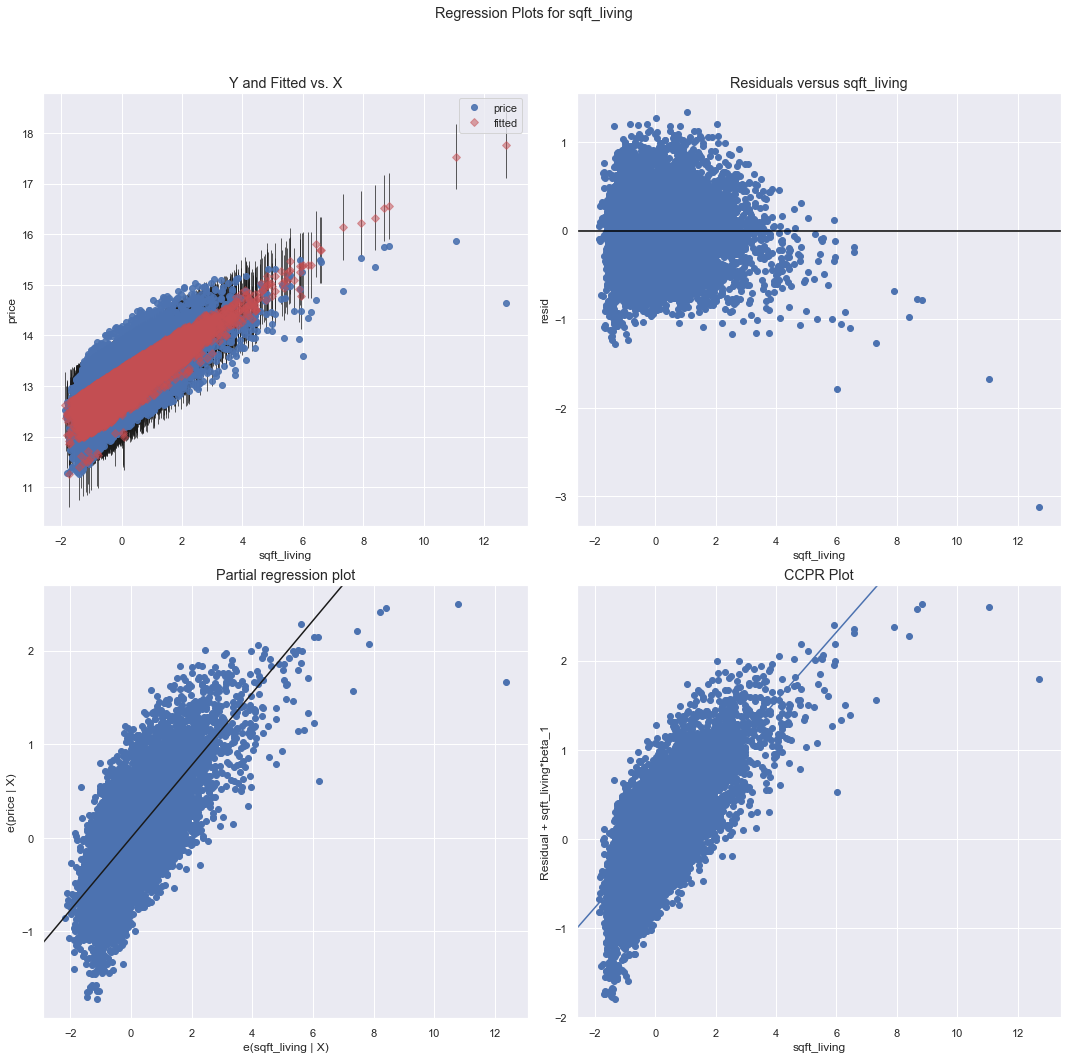

In [1001]:
fig = plt.figure(figsize=(15,15))
fig = sm.graphics.plot_regress_exog(results, 'sqft_living',fig=fig)
plt.show()

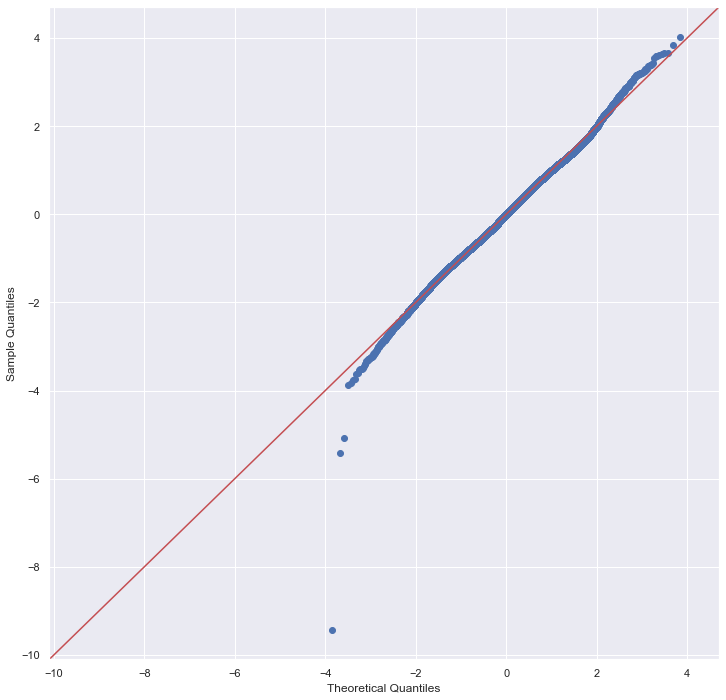

In [1002]:
residuals_multivariate_model = results.resid
fig = sm.graphics.qqplot(residuals_multivariate_model,dist=stats.norm, line='45', fit=True)
fig.show()

In [1003]:
analytic_scaled_df = sm.add_constant(analytic_scaled_df)
model_sm = sm.OLS(target_scaled_df, analytic_scaled_df)

results = model_sm.fit()

results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     9018.
Date:                Mon, 13 Apr 2020   Prob (F-statistic):               0.00
Time:                        07:02:36   Log-Likelihood:                -5373.4
No. Observations:               17277   AIC:                         1.075e+04
Df Residuals:                   17273   BIC:                         1.079e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        13.0341      0.003   5187.146      0.000      13.029      13.039
sqft_living                   0.3866      0.003    144.124      0.000       0.381       0.392
dist_highest_pricepersqft    -0.1975      0.003    -70.641      0.000      -0.203      -0.192
yr_last_updated               0.0065      0.003      2.210      0.027       0.001       0.012
==============================================================================
Omnibus:                      220.129   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              389.754
Skew:                          -0.055   Prob(JB):                     2.32e-85
Kurtosis:                       3.728   Cond. No.                         1.81
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

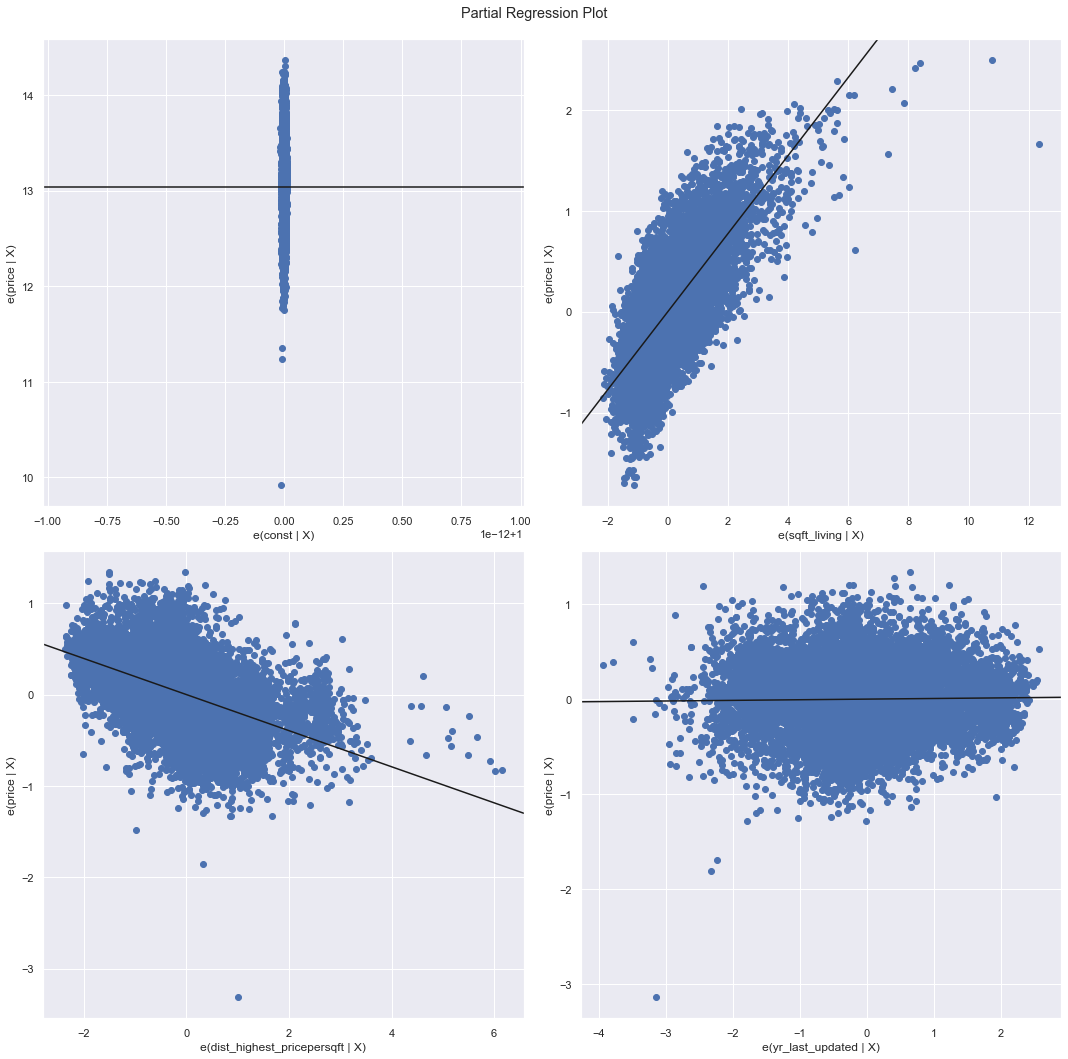

In [1004]:
fig = plt.figure(figsize=(15,15))
# fig = sm.graphics.plot_regress_exog(results,'price',fig=fig)
fig = sm.graphics.plot_partregress_grid(results, fig=fig)
plt.show()

In [1005]:
# We've decided to provide an additional model, using the log of sqft_living, because we reasoned that this would be 
# more useful to developers who are interested in how the change in square footage impacts on the change in price. 
# However, the p-value for yr_updated came at 0.186, forcing us to remove it from our developers model - see below.

analytic_scaled_df_2 = pd.DataFrame({'log_sqft_living': train_scaled_df.log_sqft_living, 'dist_highest_pricepersqft':train_scaled_df.dist_highest_pricepersqft, 'yr_last_updated':train_scaled_df.yr_last_updated})

target_scaled_df_2 = pd.DataFrame({'price':train_scaled_df.log_price})

In [1006]:
analytic_scaled_df_2 = sm.add_constant(analytic_scaled_df_2)
model_sm_2 = sm.OLS(target_scaled_df_2, 
                    analytic_scaled_df_2)

results_2 = model_sm_2.fit()

results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     8414.
Date:                Mon, 13 Apr 2020   Prob (F-statistic):               0.00
Time:                        07:02:38   Log-Likelihood:                -5734.1
No. Observations:               17277   AIC:                         1.148e+04
Df Residuals:                   17273   BIC:                         1.151e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        13.0341      0.003   5079.994      0.000      13.029      13.039
log_sqft_living               0.3848      0.003    138.623      0.000       0.379       0.390
dist_highest_pricepersqft    -0.2004      0.003    -70.184      0.000      -0.206      -0.195
yr_last_updated              -0.0040      0.003     -1.324      0.185      -0.010       0.002
==============================================================================
Omnibus:                       45.730   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.014
Skew:                           0.111   Prob(JB):                     6.18e-11
Kurtosis:                       3.125   Cond. No.                         1.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1007]:
analytic_scaled_df_2 = pd.DataFrame({'log_sqft_living': train_scaled_df.log_sqft_living, 'dist_highest_pricepersqft':train_scaled_df.dist_highest_pricepersqft})

target_scaled_df_2 = pd.DataFrame({'price':train_scaled_df.log_price})

In [1008]:
analytic_scaled_df_2 = sm.add_constant(analytic_scaled_df_2)
model_sm_2 = sm.OLS(target_scaled_df_2, analytic_scaled_df_2)

results_2 = model_sm_2.fit()

results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                 1.262e+04
Date:                Mon, 13 Apr 2020   Prob (F-statistic):               0.00
Time:                        07:02:38   Log-Likelihood:                -5735.0
No. Observations:               17277   AIC:                         1.148e+04
Df Residuals:                   17274   BIC:                         1.150e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        13.0341      0.003   5079.883      0.000      13.029      13.039
log_sqft_living               0.3835      0.003    147.989      0.000       0.378       0.389
dist_highest_pricepersqft    -0.2019      0.003    -77.929      0.000      -0.207      -0.197
==============================================================================
Omnibus:                       48.473   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.745
Skew:                           0.116   Prob(JB):                     1.58e-11
Kurtosis:                       3.124   Cond. No.                         1.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

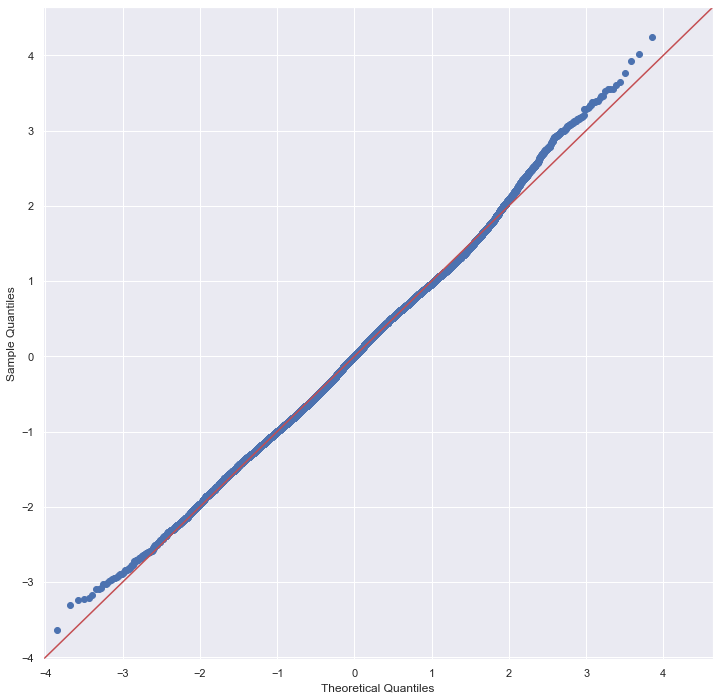

In [1009]:
residuals_multivariate_model_2 = results_2.resid
fig = sm.graphics.qqplot(residuals_multivariate_model_2,dist=stats.norm, line='45', fit=True)
fig.show()

### Hyperparameter optimization and regularization

Before turning to our test data, we select our best multivariate model from our candidate list and tune the hyperparameters such that we achieve a higher R^2 and pass in cross validation as well so that we have a move robust, generalizable model. 

In [1010]:
analytic_scaled_df.head()

const  sqft_living  dist_highest_pricepersqft  yr_last_updated
0    1.0    -0.967421                  -0.208270        -0.520941
1    1.0     0.570533                  -1.200399         0.779831
2    1.0    -1.421062                  -0.614446        -1.315857
3    1.0    -0.104396                  -0.558346        -0.159615
4    1.0    -0.414200                   0.661927         0.635301

In [1011]:
y_price_train.head()

price  price_per_sqft  log_price
0  221900.0      188.050847  12.309982
1  538000.0      209.338521  13.195614
2  180000.0      233.766234  12.100712
3  604000.0      308.163265  13.311329
4  510000.0      303.571429  13.142166

In [1012]:
model_reg_lasso = Lasso(random_state=1234, fit_intercept=True)
model_reg_ridge = Ridge(random_state=1234, fit_intercept=True)

param_lasso = [{'alpha':[0.1, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]}, {'tol': [0.001, 0.005, 0.01, 0.05, 0.1]}]
param_ridge = [{'alpha':[0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]}, {'tol': [0.001, 0.005, 0.01, 0.05, 0.1]}]


grid_lasso = GridSearchCV(estimator=model_reg_lasso,
                        param_grid=param_lasso,
                         n_jobs=-1, cv=5, scoring='r2',
                         verbose=True).fit(analytic_scaled_df, y_price_train['log_price'])

grid_ridge = GridSearchCV(estimator=model_reg_ridge,
                          param_grid=param_ridge,
                          n_jobs=-1, cv=5, scoring='r2',
                          verbose=True).fit(analytic_scaled_df, y_price_train['log_price'])


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:    1.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished


In [1013]:
best_lasso_model = grid_lasso.best_estimator_
best_ridge_model = grid_ridge.best_estimator_

print("R2 value in predicting log(price) for our best Lasso model so far is: ", best_lasso_model.score(analytic_scaled_df,  y_price_train['log_price']))
print("R2 value in predicting log(price) for our best Ridge model so far is: ",best_ridge_model.score(analytic_scaled_df,  y_price_train['log_price']))

R2 value in predicting log(price) for our best Lasso model so far is:  0.5290243029761017
R2 value in predicting log(price) for our best Ridge model so far is:  0.6103390013375024


In [1014]:
best_ridge_model.get_params()

{'alpha': 4.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': 1234,
 'solver': 'auto',
 'tol': 0.001}

Given the best parameter had an optimal parameter for a penalty coefficient of 0.1, we fill now fine-tune in the area of that coefficient to see if this can be improved upon. 

In [1015]:
analytic_scaled_df.head()

const  sqft_living  dist_highest_pricepersqft  yr_last_updated
0    1.0    -0.967421                  -0.208270        -0.520941
1    1.0     0.570533                  -1.200399         0.779831
2    1.0    -1.421062                  -0.614446        -1.315857
3    1.0    -0.104396                  -0.558346        -0.159615
4    1.0    -0.414200                   0.661927         0.635301

In [1016]:
y_price_train['price'].head()

0    221900.0
1    538000.0
2    180000.0
3    604000.0
4    510000.0
Name: price, dtype: float64

In [1017]:
param_fm_grid = [{'alpha':[3.75, 3.8, 3.85, 3.9, 3.95, 4, 4.05, 4.1, 4.15, 4.2, 4.25, 4.3, 4.35, 4.4, 4.45]}, 
                 {'tol': [0.0007, 0.0008, 0.0009,0.001, 0.0011, 0.0012, 0.0013]}]
model_fm = Ridge(random_state=1234)

grid_ridge_fm = GridSearchCV(estimator=model_fm,
                          param_grid=param_fm_grid,
                          n_jobs=-1, cv=5, scoring='r2',
                          verbose=True).fit(analytic_scaled_df, y_price_train['log_price'])

ridge_fm_model = grid_ridge_fm.best_estimator_
ridge_fm_model.score(analytic_scaled_df, y_price_train['log_price'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    0.4s finished


0.610338991737103

In [1018]:
ridge_fm_model.get_params()

{'alpha': 4.45,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': 1234,
 'solver': 'auto',
 'tol': 0.001}

So we take our final candidate to be a Linear Regression model with L2 ("Ridge") regularization and with a penalty coefficient of 4.45.

<a id='Testing-our-model'></a>

### 4.3 Testing our model


A note on implementation: although displaying full model results is easier in statsmodel's OLS module, that library currently has no support for L1 or L2 regularization. Therefore, we will be using the sklearn estimator object we instantiated earlier. 

In [1019]:
test_scaled_df.head()

index  sqft_living  sqft_living15  renovated  yr_last_updated  \
0      0     0.238601       0.066433  -0.194056        -0.087350   
1      1    -0.646552      -0.750095  -0.194056         1.285687   
2      2    -0.856776      -1.210320  -0.194056         0.237843   
3      3     0.858208       1.268957  -0.194056         1.285687   
4      4    -0.093332       0.007049  -0.194056        -2.219170   

   dist_highest_price_prop  dist_highest_pricepersqft  dist_from_needle  \
0                -0.700723                  -0.709380         -0.555773   
1                 1.094641                   1.099616          1.166525   
2                 0.614597                   0.462545          0.734994   
3                 0.261191                   0.462249          0.299367   
4                -1.201451                  -1.058244         -1.052427   

   log_sqft_living  index     price  price_per_sqft  log_price  
0         0.447000  17277  624900.0      275.286344  13.345347  
1        -0.585430  17278  379770.0      258.346939  12.847321  
2        -0.914279  17279  340000.0      265.625000  12.736701  
3         0.970909  17280  515500.0      182.155477  13.152893  
4         0.110205  17281  600000.0      304.568528  13.304685

In [1020]:
test_input_scaled_df = pd.DataFrame({'sqft_living': test_scaled_df.sqft_living, 'dist_highest_pricepersqft':test_scaled_df.dist_highest_pricepersqft, 'yr_last_updated':test_scaled_df.yr_last_updated})
test_input_scaled_df.head()

sqft_living  dist_highest_pricepersqft  yr_last_updated
0     0.238601                  -0.709380        -0.087350
1    -0.646552                   1.099616         1.285687
2    -0.856776                   0.462545         0.237843
3     0.858208                   0.462249         1.285687
4    -0.093332                  -1.058244        -2.219170

In [1021]:
test_input_scaled_df = sm.add_constant(test_input_scaled_df)
test_input_scaled_df.head()

const  sqft_living  dist_highest_pricepersqft  yr_last_updated
0    1.0     0.238601                  -0.709380        -0.087350
1    1.0    -0.646552                   1.099616         1.285687
2    1.0    -0.856776                   0.462545         0.237843
3    1.0     0.858208                   0.462249         1.285687
4    1.0    -0.093332                  -1.058244        -2.219170

In [1022]:
log_price_pred = ridge_fm_model.predict(test_input_scaled_df)


In [1023]:
eval_results = pd.DataFrame({'actual_log_price': test_scaled_df.log_price, 
                             'pred_log_price':log_price_pred, 
                             'error':abs(test_scaled_df.log_price - log_price_pred)})


In [1024]:
eval_results.head()

actual_log_price  pred_log_price     error
0         13.345347       13.265818  0.079529
1         12.847321       12.575473  0.271848
2         12.736701       12.613159  0.123542
3         13.152893       13.282926  0.130033
4         13.304685       13.192444  0.112241

In [1025]:
eval_results.describe()

actual_log_price  pred_log_price        error
count       4320.000000     4320.000000  4320.000000
mean          13.104705       13.093516     0.244470
std            0.512596        0.418995     0.185168
min           11.326596       11.691047     0.000085
25%           12.751300       12.814954     0.105719
50%           13.071070       13.031946     0.209841
75%           13.415033       13.310808     0.339682
max           15.150512       15.644313     1.422683

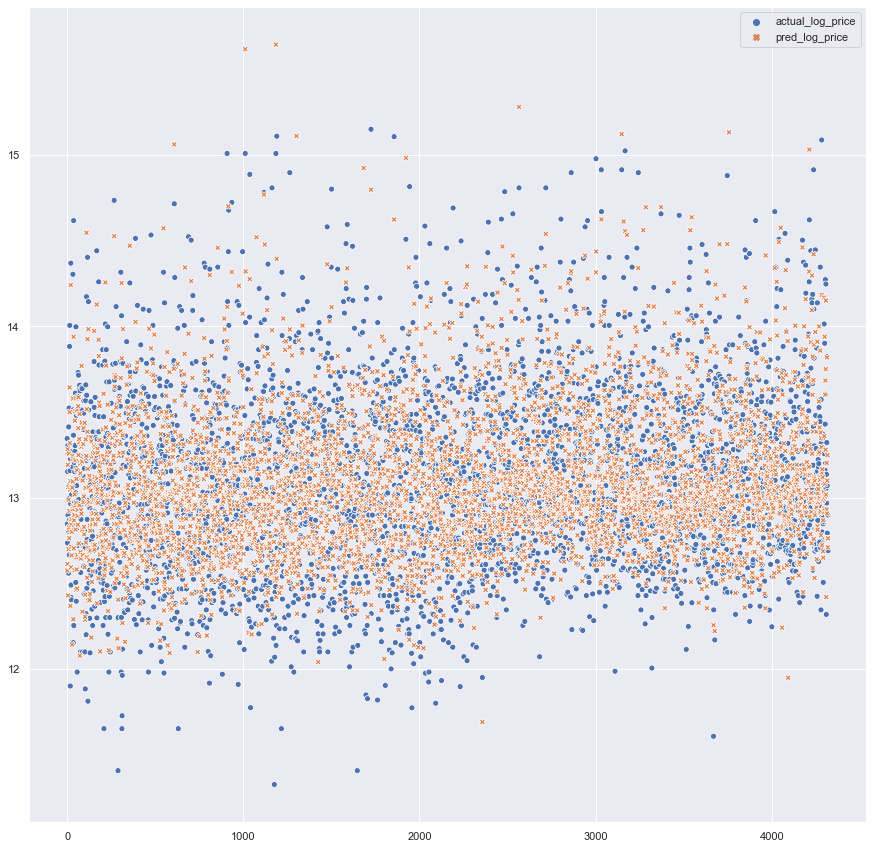

In [1026]:
fig = plt.figure(figsize=(15,15))

sns.scatterplot(data=eval_results.drop(columns='error'))
plt.show()

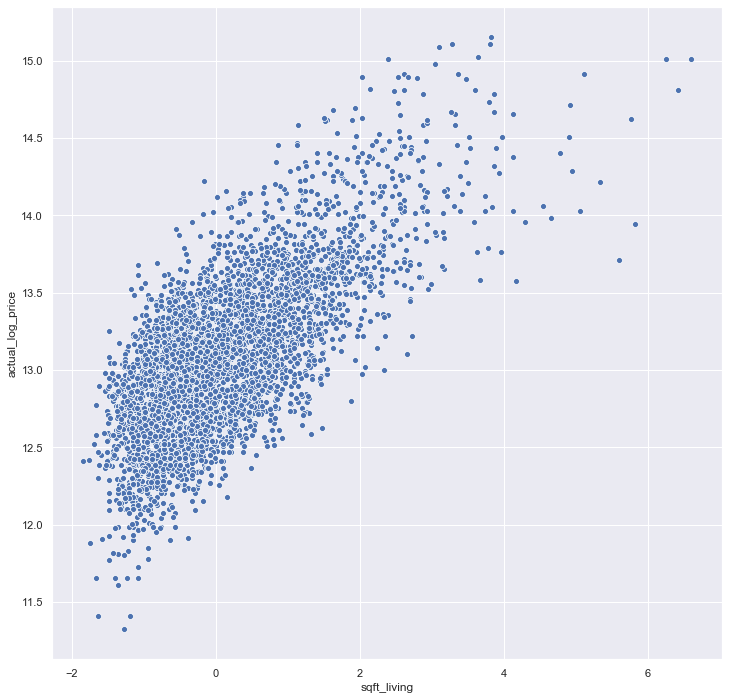

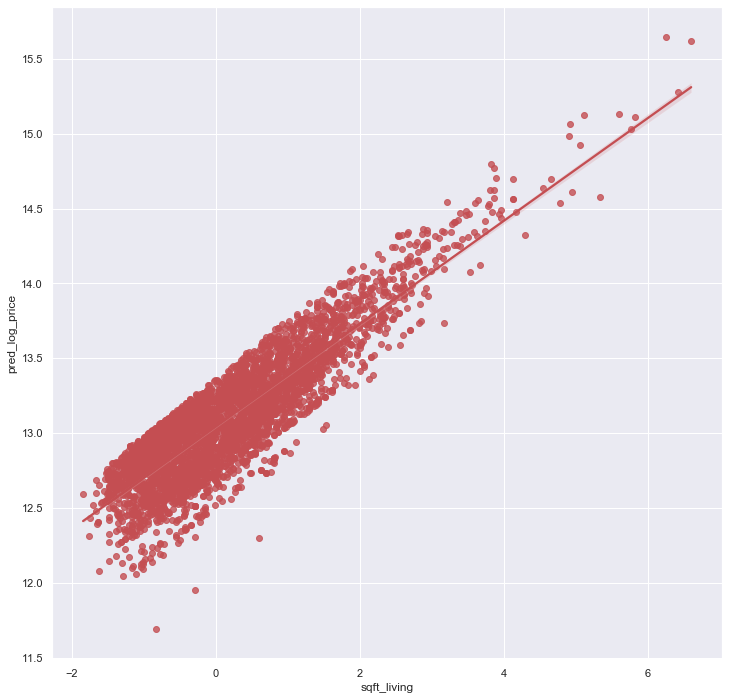

In [1027]:
sns.scatterplot(y=eval_results.actual_log_price,x=test_scaled_df.sqft_living)
plt.figure(figsize=(12,12))
sns.regplot(test_scaled_df.sqft_living, eval_results.pred_log_price,color='r')
plt.show()

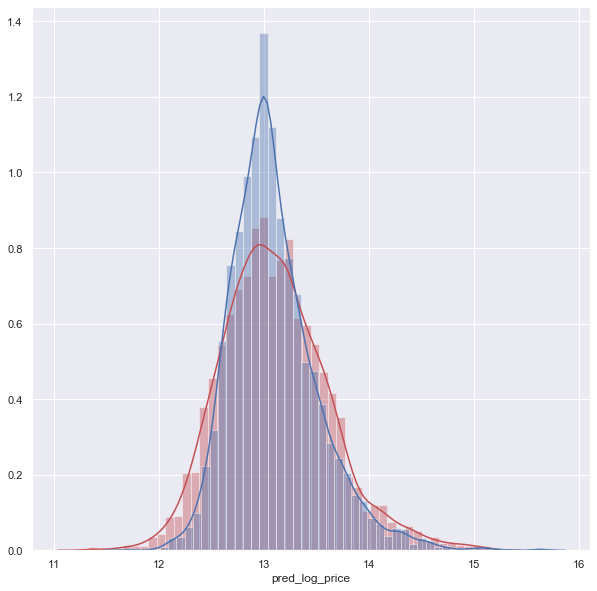

In [1028]:
plt.figure(figsize=(10,10))
sns.distplot(eval_results.actual_log_price, color='r')
sns.distplot(eval_results.pred_log_price, color='b')

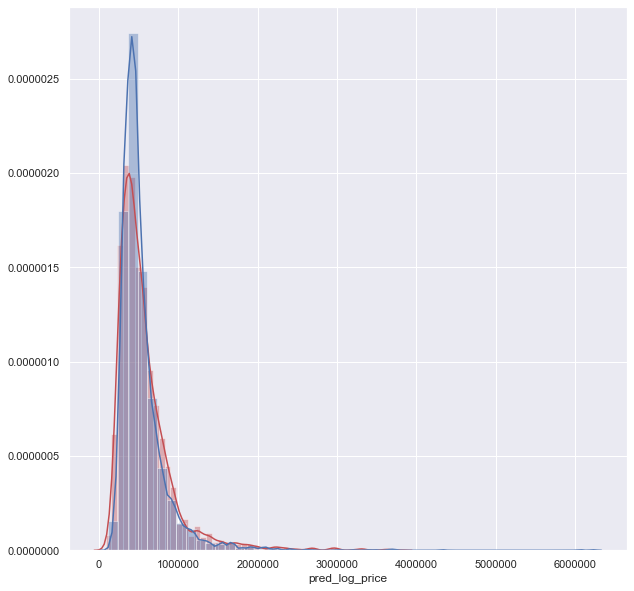

In [1029]:
plt.figure(figsize=(10,10))
sns.distplot(np.exp(eval_results.actual_log_price), color='r')
sns.distplot(np.exp(eval_results.pred_log_price), color='b')

<Figure size 1008x1008 with 0 Axes>

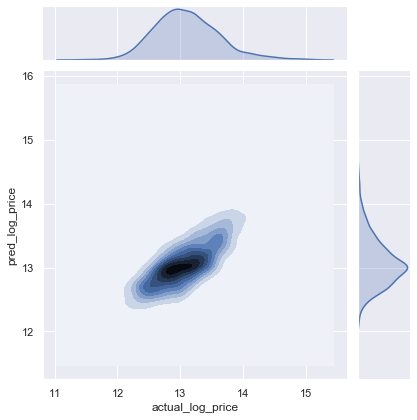

In [1030]:
plt.figure(figsize=(14,14));
sns.jointplot(eval_results.actual_log_price,eval_results.pred_log_price,kind='kde');

In [1031]:
ridge_fm_model.coef_

array([ 0.        ,  0.38649821, -0.19747815,  0.00655604])

For the purposes of showing our stakeholders what changes you can expect from changes in property, we've written a simple function based on our chosen final input variables.This can be used for predicting the log of price (which can be interpreted as "change in price"), using the square footage of living space, the year when the property was last modified and the distance from the property with the highest price per square foot. 

In [1032]:
# writing in a quick function for outputting a predicted price given values for sqft_living, yr_last_modified 
# and dist_highest_pricepersqft
def simple_predictor_log_price(sqftliving, yr_mod, dist_high):
    scaler = StandardScaler()
    scaler.fit(x_train[['sqft_living', 'yr_last_updated', 'dist_highest_pricepersqft']])
    input_data = pd.DataFrame({'sqft_living_scaled':[sqftliving], 
                               'yr_last_updated_scaled':[yr_mod], 
                               'dist_highest_pricepersqft_scaled':[dist_high]})
    scaled_input_data = pd.DataFrame(scaler.transform(input_data), columns=input_data.columns)
    sqftliving_input = scaled_input_data.sqft_living_scaled
    yr_mod_input = scaled_input_data.yr_last_updated_scaled
    dist_highest_priceper_sqft_input = scaled_input_data.dist_highest_pricepersqft_scaled
    
    scaled_input_data['predicted_log_price'] = 0.38649821*sqftliving_input - 0.19747815*yr_mod_input + 0.00655604*dist_highest_priceper_sqft_input
    return scaled_input_data

In [1033]:
 simple_predictor(1500, 2009, 0.05)

sqft_living_scaled  yr_last_updated_scaled  \
0           -0.613359                1.430217   

   dist_highest_pricepersqft_scaled  predicted_log_price  
0                         -1.367249            -0.528463

In [1034]:
simple_predictor(3000, 2009, 0.05)

sqft_living_scaled  yr_last_updated_scaled  \
0            1.046303                1.430217   

   dist_highest_pricepersqft_scaled  predicted_log_price  
0                         -1.367249             0.112994

In [1035]:
simple_predictor(clean_df.sqft_living.mean(), 2009, 0.05)

sqft_living_scaled  yr_last_updated_scaled  \
0            0.028733                1.430217   

   dist_highest_pricepersqft_scaled  predicted_log_price  
0                         -1.367249            -0.280295

In [1036]:
x = simple_predictor(3000, 2009, 0.05)['predicted_log_price'][0]/simple_predictor(1500, 2009, 0.05)['predicted_log_price'][0];
print("% increase from doubling sqft_living :", round((abs(x)-1)*100,2))

% increase from doubling sqft_living : -78.62


In [1037]:
a = simple_predictor(1500, 1970, 0.05)['predicted_log_price'][0]
b = simple_predictor(1500, 2010, 0.05)['predicted_log_price'][0]
print("% increase from updating a 40 year old house from 1970 in 2010:", round(((b/a)-1)*100,2))

% increase from updating a 40 year old house from 1970 in 2010: 114.08


In [1038]:
a = simple_predictor(1500, 1920, 0.05)['predicted_log_price'][0]
b = simple_predictor(1500, 2010, 0.05)['predicted_log_price'][0]
print("% increase from updating a 90 year old house from 1920 in 2010 :", round(((b/a)-1)*100,2))

% increase from updating a 90 year old house from 1920 in 2010 : -602.5


In [1039]:
a = simple_predictor(1500, 2009, 0.2)['predicted_log_price'][0]
b = simple_predictor(1500, 2009, 0.1)['predicted_log_price'][0]
print("A house ~11km closer to the price nucleus of KC will be :", round(((b/a)-1)*100,2), "% more expensive on average.")

A house ~11km closer to the price nucleus of KC will be : 0.85 % more expensive on average.


<a id=heatmap></a>

Visualizations: for the purposes of our exploration we've chosen the location within KC as a relatively good predictor of price. To support our argument, we've built a heatmap of the price over the map, using folium. 

In [1040]:
mapping_df = pd.DataFrame({'price':clean_df['price'], 'latitude':clean_df['lat'], 'longitude':clean_df['long'], 'price_persqft':clean_df['price_per_sqft']})
print(len(mapping_df))
def generate_base_map(default_location = [mapping_df.latitude.median(),mapping_df.longitude.median()],default_zoom_start=10):
    base_map = folium.Map(location = default_location, control_scale=False, zoom_start = default_zoom_start)
    return base_map

base_map = generate_base_map(default_zoom_start=10)

map_gradient = {0.45: 'blue', 0.6: 'lime', 0.9: 'red'}


from folium.plugins import HeatMap
HeatMap(data = mapping_df[['latitude','longitude','price']],radius = 7, gradient = map_gradient).add_to(base_map);

21597


In [888]:
# Below we've plotted the heat map of absolute price
base_map

In [1041]:
next_map = generate_base_map()
map_gradient_2 = {0.45: 'blue', 0.6: 'lime', 0.9: 'red'}

HeatMap(data = mapping_df[['latitude','longitude','price_persqft']],radius = 7, max_zoom = 10, gradient = map_gradient_2).add_to(next_map)

In [1042]:
# Below we've plotted the heat map of price per square foot
next_map

<a id='Conclusion'></a>

## 5. Conclusion


    1. Is the amount of square foot of living space an effective predictor of house price and if so, by how much?
   [Model with only sqft_living](#univariatesqft_living); 
   [Multivariate model](#multivariatemodel)
   
    Square footage of living space was found to be the most impactful predictor of the logarithm of sale price (R^2 = 0.476), and its residuals were generally scale-independent, except at the very top end of the price scale. NB: our multivariate model relied heavily on this as a variable (R^2 of entire model = 0.61). 
    
    2. Assuming that houses that have not been rennovated were last modified in the year that they were built, is there a correlation between the year that houses were last modified and their price? 
    The correlation between the year of last modifications and the logarithm of price was very weak and in some cases made our model weaker. Renovation did increase house sale price on average, however, even discounting the unrenovated houses, renovation was a very poor predictor of house price. 
    
    3. If we plot the location of houses in KC across the county map, are there any particular geographical areas that have a strong correlation with price? (see heatmap in section 4.3)
[heatmap](#heatmap)

    There was a mild correlation between the distance from the property with the highest price per square foot. There are pockets of higher prices distributed across the county, which can be used as an additional predictor of your price band when setting your sale value. 
    


##### Sub questions:    
     - what is the level of spending on square footage (during building or rennovation) that will typically lead to a profit when selling the house)?
      The average level of spending per sqft is shown just below. Generally developers should aim to keep their build cost below this level in order to profit from a sale. 

In [1043]:
clean_df.price_per_sqft.mean().round(2)

264.14

    - If building houses at the same cost, will location be a factor?
    Generally yes, as indicated in the heatmap in section 4. 
    - Is this a good indication for maximising profits for a development company?
    Without more data (e.g. on labor and material costs) we are unable to tell if this maximizes profit for a development company.